## CAIXABANK Hackathon - Data Science

# COLUMNES TRAIN/TEST MATEIX ORDRE
# EDA 3 DATASETS

### IMPORT MODULES

In [ ]:
!pip3 install xgboost

In [23]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime
import scipy

import re
sns.set()
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import warnings

from utils import utils, sentiment_tweet, train


### DATA LOAD

#### STOCK

Load train data

In [2]:
path_stock, extension_stock = utils.get_path('train.csv')
df_stock = utils.get_dataframe(path_stock, extension_stock)
df_stock.head(2)

Date         Open         High          Low        Close  \
0  1994-01-03  3615.199951  3654.699951  3581.000000  3654.500000   
1  1994-01-04  3654.500000  3675.500000  3625.100098  3630.300049   

     Adj Close  Volume  Target  
0  3654.496338     0.0       0  
1  3630.296387     0.0       1

Load test data

In [3]:
path_stock_test, extension_stock_test = utils.get_path('test_x.csv')
df_stock_test = utils.get_dataframe(path_stock_test, extension_stock_test)
df_stock_test.head(2)

test_index        Date         Open         High          Low        Close  \
0        6557  2019-06-05  9136.799805  9173.400391  9095.000000  9150.500000   
1        6558  2019-06-06  9169.200195  9246.200195  9136.700195  9169.200195   

     Adj Close       Volume  
0  9150.500000  158753000.0  
1  9169.200195  212720900.0

#### TWEETS

Load train data

In [4]:
path_tweets, extension_tweets = utils.get_path('tweets_from2015_#Ibex35.csv')
df_tweets = utils.get_dataframe(path_tweets, extension_tweets)
df_tweets['date'] = df_tweets.apply(lambda row: sentiment_tweet.change_data(row, 'tweetDate'),axis=1)
df_tweets.head(2)

tweetDate         handle  \
0  Sat Apr 09 14:47:45 +0000 2022       abelac62   
1  Thu Apr 07 19:14:36 +0000 2022  LluisPerarnau   

                                                text        date  
0  He hecho el repaso de todos los componentes de...  2022-04-09  
1  Els projectes que han presentat les empreses d...  2022-04-07

Create csv file adding a column score

In [5]:
#sentiment_tweet.twitter_sentiment_csv(df_tweets)

Load file with score

In [6]:
path_tweets_full, extension_tweets_full = utils.get_path('twitter_processed.csv')
df_tweets_full = utils.get_dataframe(path_tweets_full, extension_tweets_full)
df_tweets_full.head(2)

Unnamed: 0                       tweetDate         handle  \
0           0  Sat Apr 09 14:47:45 +0000 2022       abelac62   
1           1  Thu Apr 07 19:14:36 +0000 2022  LluisPerarnau   

                                                text        date  \
0  He hecho el repaso de todos los componentes de...  2022-04-09   
1  Els projectes que han presentat les empreses d...  2022-04-07   

                                               clean   score  
0  he hecho el repaso de todos los componentes de...  0.7964  
1  els projectes que han presentat les empreses d...  0.0000

In [7]:
total = df_tweets_full['score'].astype(bool).sum(axis=0)
shape = df_tweets_full.shape
f'We scored {total} of {shape[0]} tweets. {total/shape[0]}%. Remaining tweets require a deeper analysis to understand the message.'


'We scored 6550 of 9801 tweets. 0.668299153147638%. Remaining tweets require a deeper analysis to understand the message.'

There are days with more than one tweet. That is why we will calculate the average daily score. The days without tweets we will put a neutral evaluation.

In [8]:
df_tweets_score = df_tweets_full.groupby('date', as_index=False, sort=False)['score'].mean()
df_tweets_score = df_tweets_score.sort_values(by="date")
df_tweets_score

date     score
1418           0  0.000000
2355  2015-01-03  0.000000
2353  2015-01-04  0.441700
2347  2015-01-05 -0.213600
2352  2015-01-06  0.395567
...          ...       ...
3     2022-04-05 -0.190900
9     2022-04-06  0.102700
1     2022-04-07  0.369725
5     2022-04-08  0.032500
0     2022-04-09  0.534800

[2356 rows x 2 columns]

## PYTRENDS

In [9]:
path_pytrends, extension_pytrends = utils.get_path('pytrends_data.csv')
df_pytrends = utils.get_dataframe(path_pytrends, extension_pytrends)
df_pytrends.head(2)

date  Ibex 35  ibex 35 down  credito  recesión  Ibex 35%  \
0  2014-06-05       68             0       89        28     -4.23   
1  2014-06-06       79             0       88         8     16.18   

   ibex 35 down%  credito%  recesión%  
0            0.0      0.00      -9.68  
1            0.0     -1.12     -71.43

# EDA

### STOCK

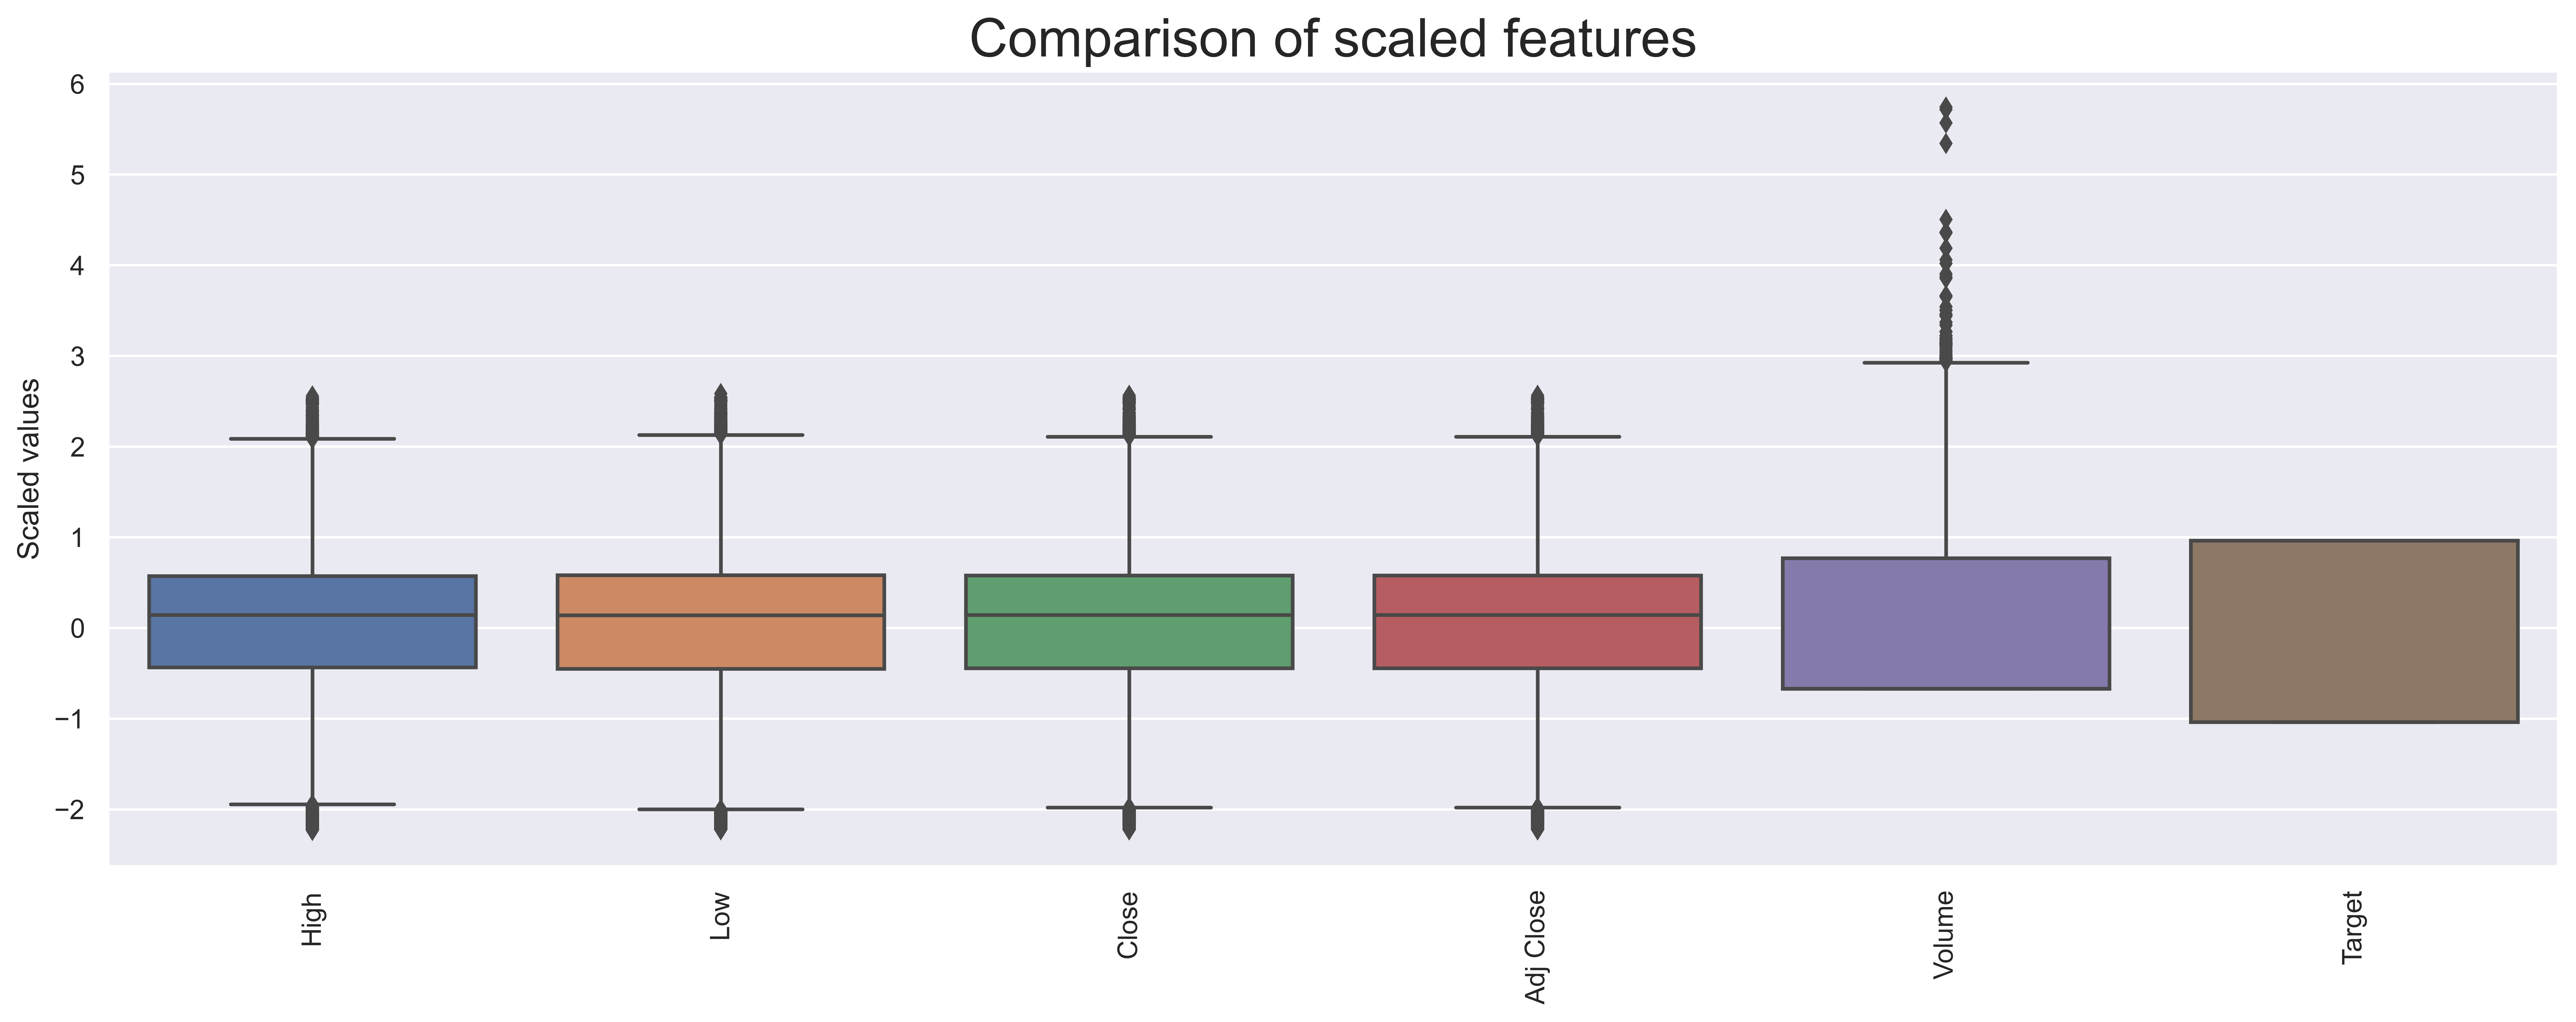

In [10]:
#creating new dataframe for scaled feature values by first copying the original dataframe
df_features_scaled = df_stock.iloc[:,2:26].copy()

utils.plot_features(df_features_scaled)

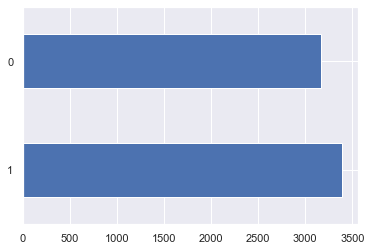

In [11]:
hist = df_stock.Target.value_counts()[:20].plot(kind='barh')

### TWITTER

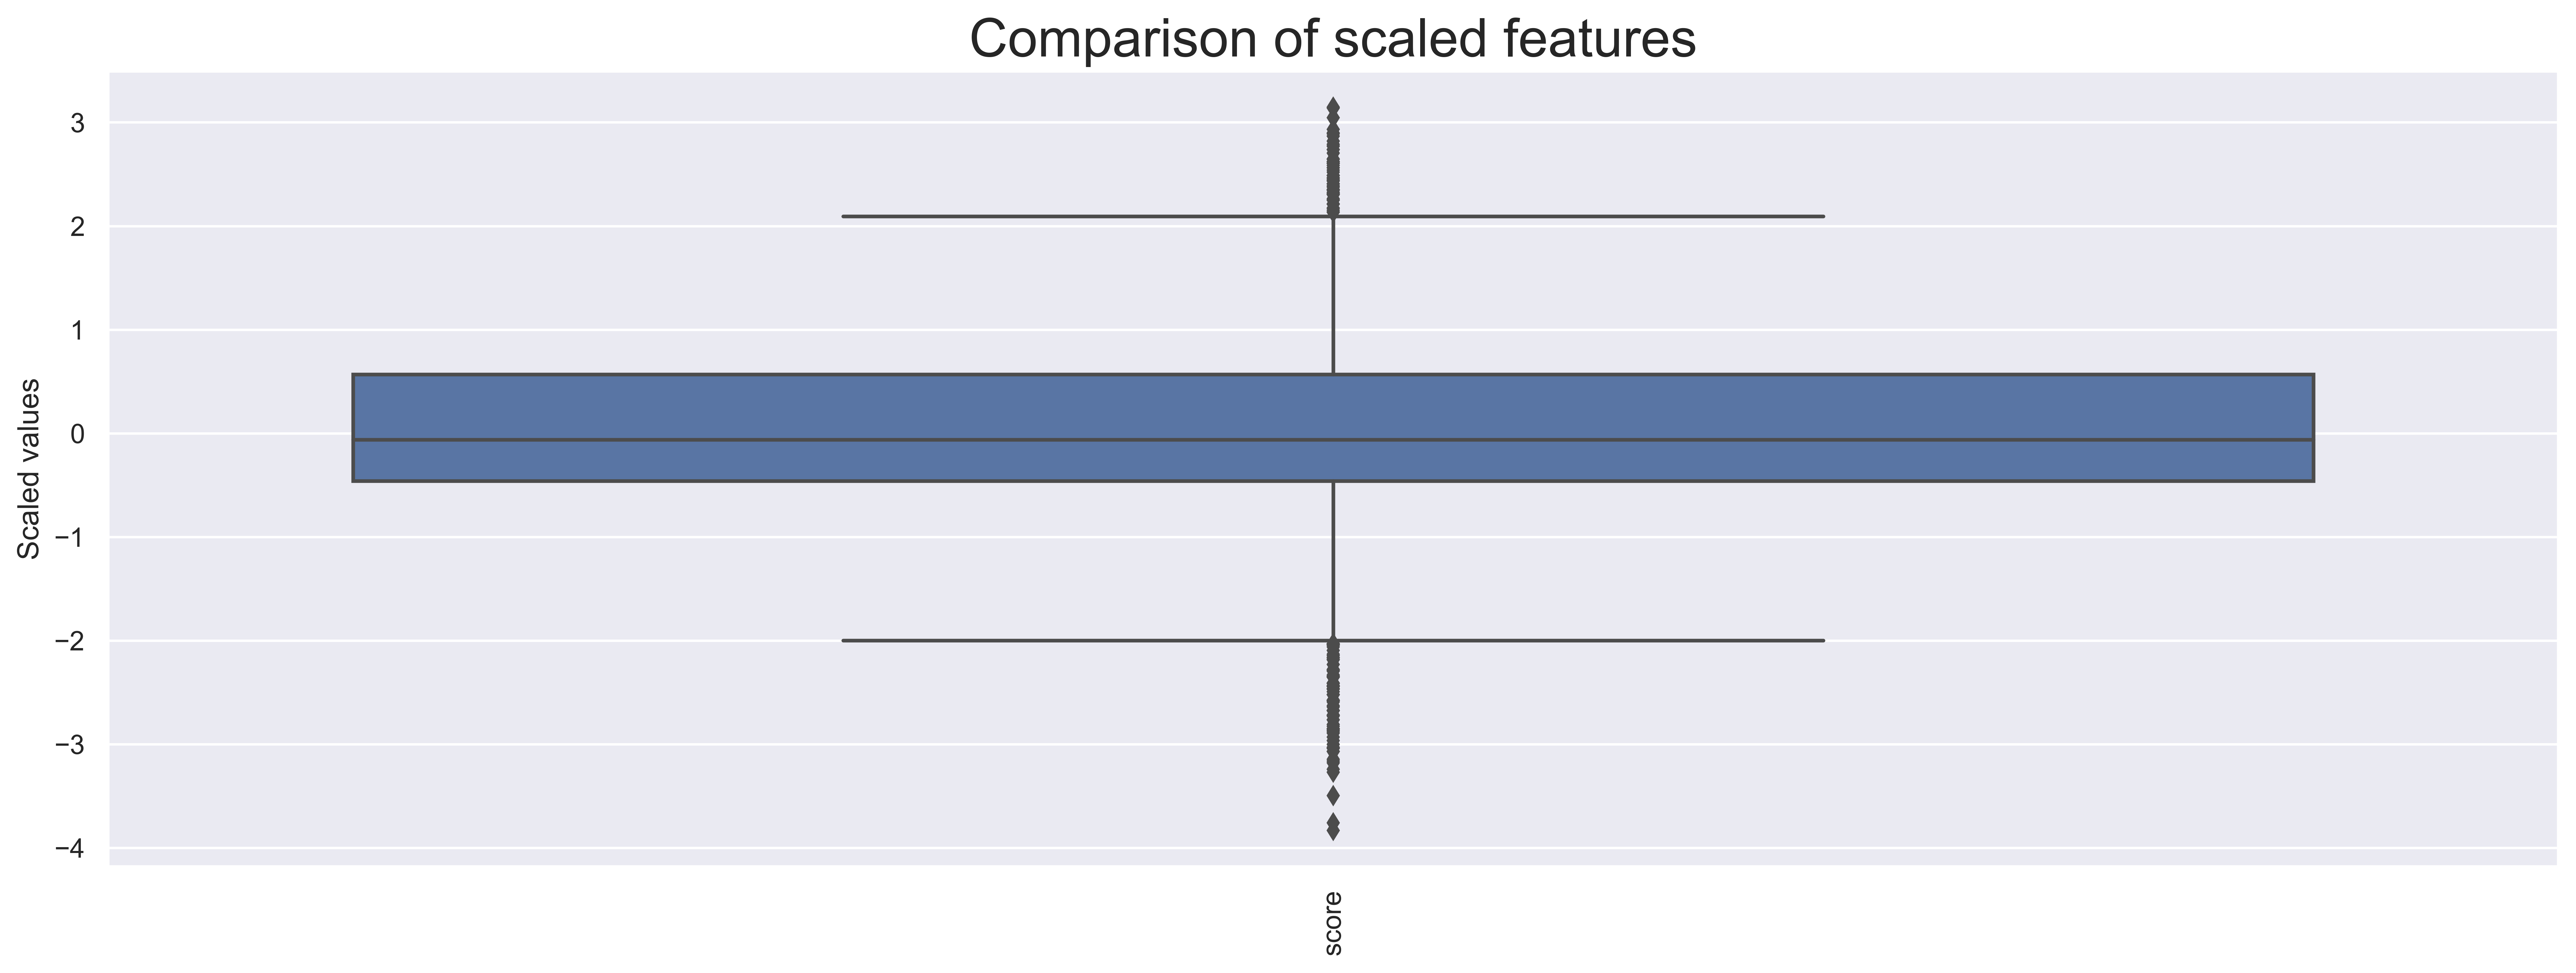

In [12]:
#creating new dataframe for scaled feature values by first copying the original dataframe
df_features_scaled = df_tweets_score.iloc[:,1:26].copy()

utils.plot_features(df_features_scaled)

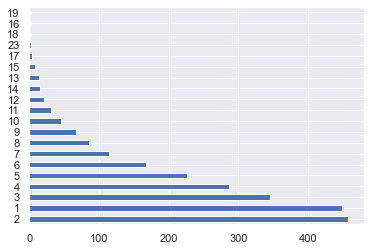

In [39]:
data_tweets = df_tweets_full.groupby('date').count()
hist = data_tweets.score.value_counts()[:20].plot(kind='barh')

### PYTRENDS

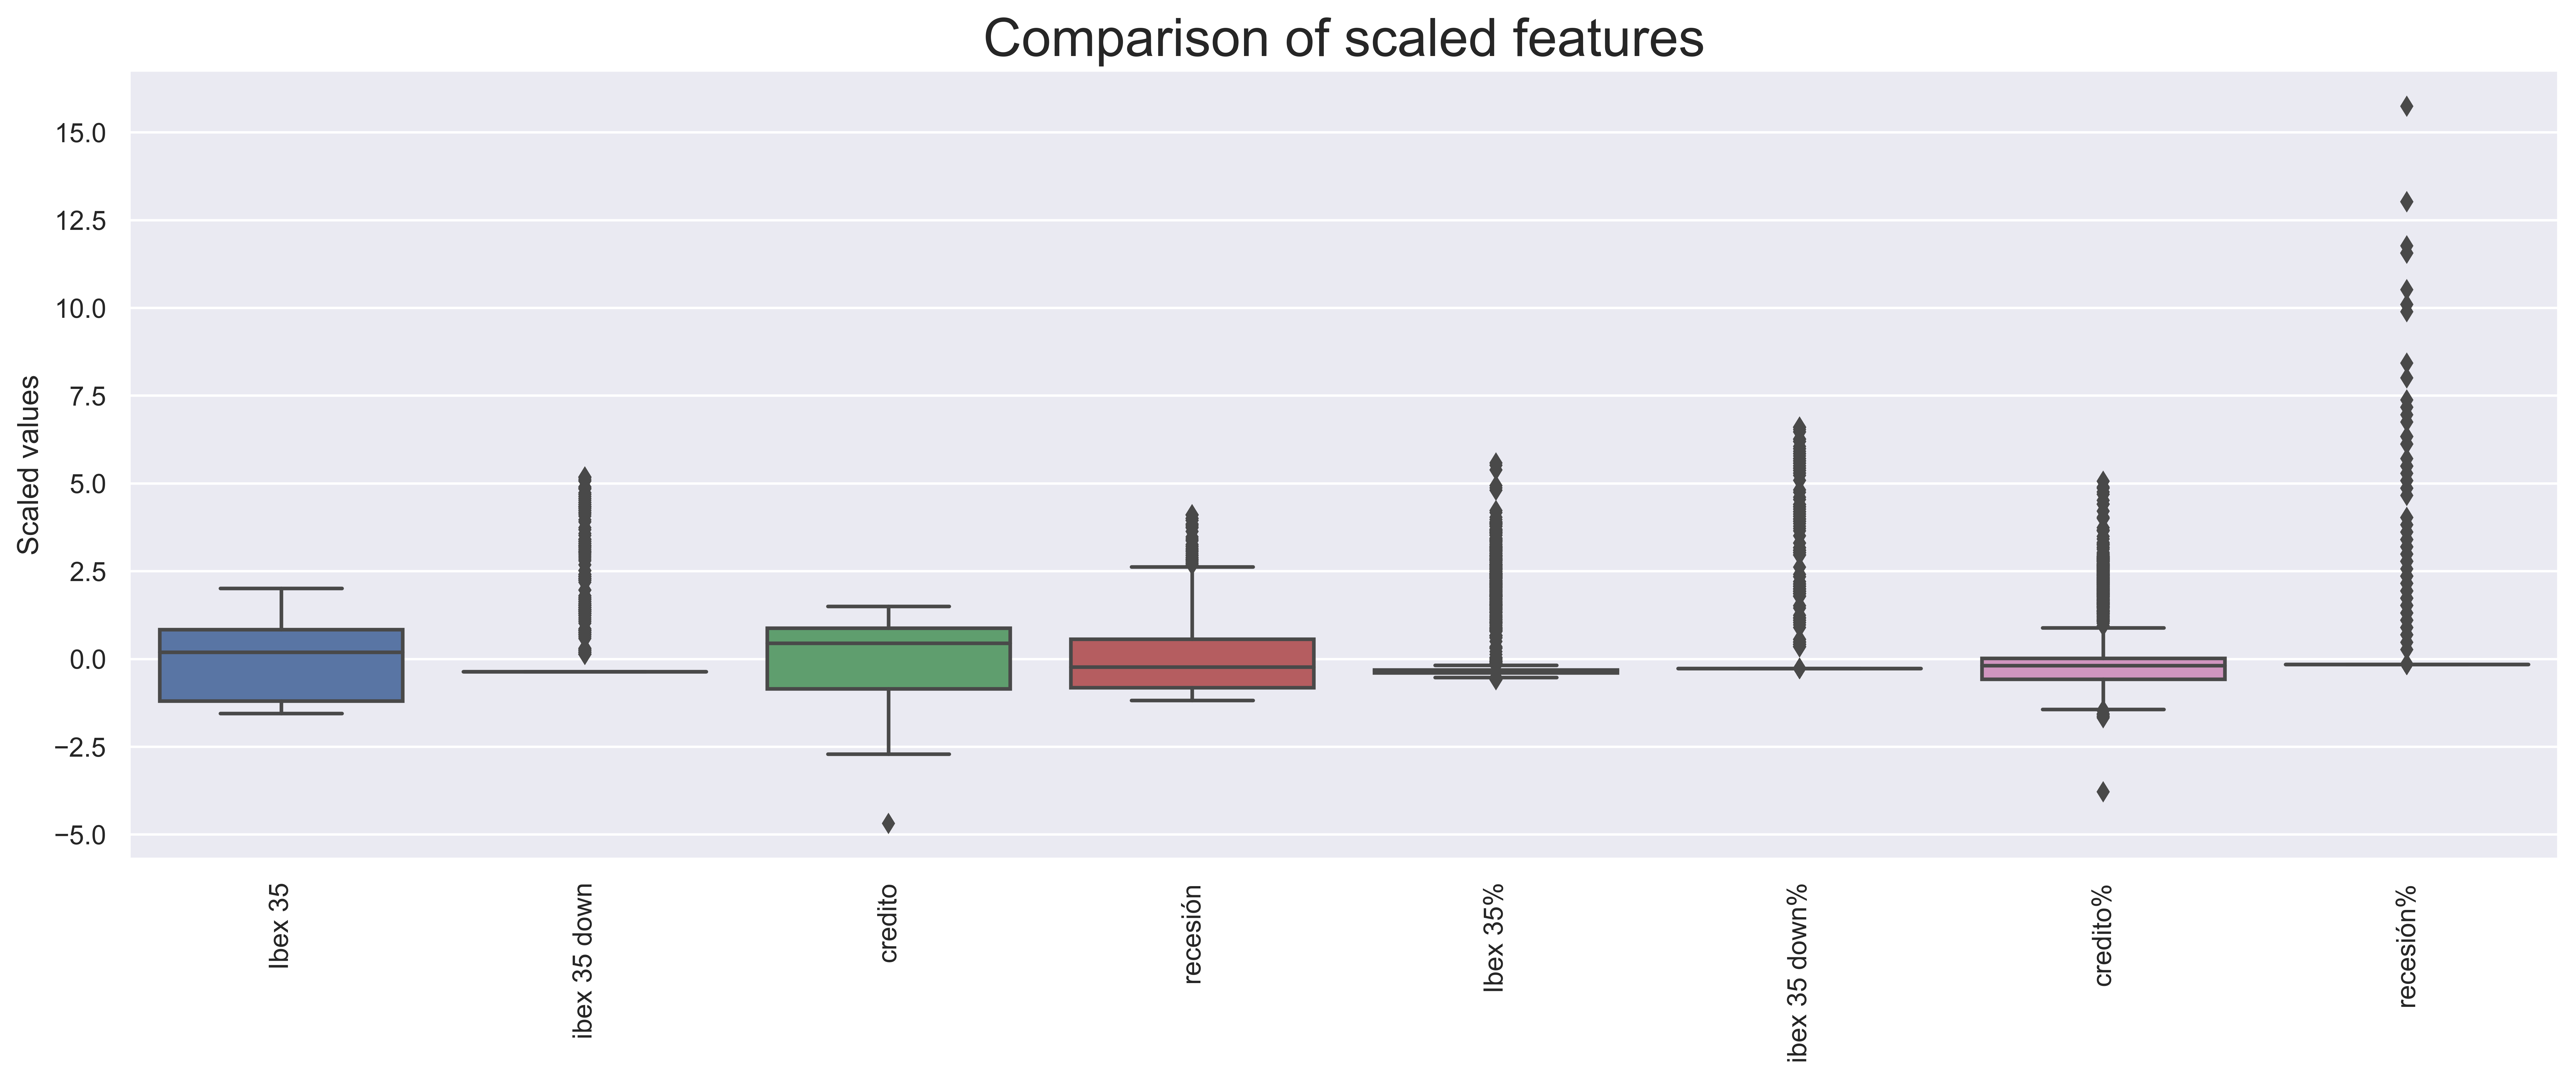

In [13]:
#creating new dataframe for scaled feature values by first copying the original dataframe
df_features_scaled = df_pytrends.iloc[:,1:].copy()

utils.plot_features(df_features_scaled)

## COMBINE DATA

We will create a dataset with columns from all three data sources. Let's review the structure

In [14]:
df_pytrends.head(2)

date  Ibex 35  ibex 35 down  credito  recesión  Ibex 35%  \
0  2014-06-05       68             0       89        28     -4.23   
1  2014-06-06       79             0       88         8     16.18   

   ibex 35 down%  credito%  recesión%  
0            0.0      0.00      -9.68  
1            0.0     -1.12     -71.43

In [15]:
df_stock.head(2)

Date         Open         High          Low        Close  \
0  1994-01-03  3615.199951  3654.699951  3581.000000  3654.500000   
1  1994-01-04  3654.500000  3675.500000  3625.100098  3630.300049   

     Adj Close  Volume  Target  
0  3654.496338     0.0       0  
1  3630.296387     0.0       1

In [37]:
df_tweets_full.groupby('date').count()['score']

date
0             7
2015-01-03    1
2015-01-04    1
2015-01-05    5
2015-01-06    3
             ..
2022-04-05    2
2022-04-06    1
2022-04-07    4
2022-04-08    2
2022-04-09    2
Name: score, Length: 2356, dtype: int64

In [16]:
df_tweets_score.tail(2)

date   score
5  2022-04-08  0.0325
0  2022-04-09  0.5348

Create train dataset

In [17]:
df_global = df_pytrends.set_index('date').join(df_stock.set_index('Date'))
df_global = df_global.join(df_tweets_score.set_index('date'))
#df_global_twitter.sentiment = df_global_twitter.sentiment.fillna(0)
#df_global 
df = df_global.apply (pd.to_numeric, errors='coerce')
df = df.dropna()
df


Ibex 35  ibex 35 down  credito  recesión  Ibex 35%  ibex 35 down%  \
2015-01-05       65             0       92        11    712.41            0.0   
2015-01-06       55             0       89        36    -15.38            0.0   
2015-01-07       75             0       89         4     36.36            0.0   
2015-01-08       81             0       92        11      8.00            0.0   
2015-01-09       95             0       91        18     17.28            0.0   
...             ...           ...      ...       ...       ...            ...   
2019-05-24       76             0       90        13     11.76            0.0   
2019-05-27       65             0       93        44    828.45            0.0   
2019-05-28       68             0       93        49      4.62            0.0   
2019-05-29       63             0       94        49     -7.35            0.0   
2019-05-30       76             0       97        57     20.63            0.0   

            credito%  recesión%          Open          High          Low  \
2015-01-05     76.92     -35.29  10267.200195  10390.799805  9977.799805   
2015-01-06     -3.26     227.25  10040.700195  10060.799805  9871.099609   
2015-01-07      0.00     -88.89   9937.299805  10051.200195  9836.400391   
2015-01-08      3.37     174.96  10053.200195  10143.000000  9970.299805   
2015-01-09     -1.09      63.63  10080.000000  10080.000000  9610.099609   
...              ...        ...           ...           ...          ...   
2019-05-24     -2.17     -73.47   9150.299805   9211.099609  9141.400391   
2019-05-27     45.31     100.00   9225.900391   9294.599609  9204.700195   
2019-05-28      0.00      11.36   9220.400391   9224.900391  9132.900391   
2019-05-29      1.08       0.00   9113.200195   9116.700195  9035.099609   
2019-05-30      3.19      16.33   9120.799805   9175.200195  9114.099609   

                   Close     Adj Close       Volume  Target     score  
2015-01-05   9993.299805   9993.290039  299610800.0     1.0 -0.213600  
2015-01-06   9871.099609   9871.089844  282855400.0     0.0  0.395567  
2015-01-07   9891.400391   9891.390625  290122400.0     0.0  0.000000  
2015-01-08  10115.000000  10114.990234  320452300.0     0.0  0.000000  
2015-01-09   9719.000000   9718.990234  789490200.0     1.0  0.226300  
...                  ...           ...          ...     ...       ...  
2019-05-24   9174.599609   9174.599609  121673100.0     0.0  0.137075  
2019-05-27   9216.400391   9216.400391   60178000.0     0.0 -0.023250  
2019-05-28   9191.799805   9191.799805  218900800.0     0.0 -0.048240  
2019-05-29   9080.500000   9080.500000  148987100.0     0.0  0.025900  
2019-05-30   9157.799805   9157.799805  101389200.0     0.0  0.157900  

[1067 rows x 16 columns]

Create test Dataset

In [19]:
df_pred = df_stock_test.set_index('Date').join(df_pytrends.set_index('date'))
df_pred = df_pred.join(df_tweets_score.set_index('date'))
df_pred = df_pred[~df_pred.index.duplicated(keep='first')]#[~df_pred.index.duplicated(keep='first')]
df_pred 

test_index         Open         High          Low        Close  \
2019-06-05        6557  9136.799805  9173.400391  9095.000000  9150.500000   
2019-06-06        6558  9169.200195  9246.200195  9136.700195  9169.200195   
2019-06-07        6559  9186.700195  9261.400391  9185.700195  9236.099609   
2019-06-10        6560  9284.200195  9302.200195  9248.099609  9294.099609   
2019-06-11        6561  9288.599609  9332.500000  9273.400391  9282.099609   
...                ...          ...          ...          ...          ...   
2022-03-25        7278  8314.099609  8363.200195  8286.500000  8330.599609   
2022-03-28        7279  8354.400391  8485.700195  8354.400391  8365.599609   
2022-03-29        7280  8451.000000  8621.000000  8419.700195  8614.599609   
2022-03-30        7281  8583.299805  8597.400391  8508.900391  8550.599609   
2022-03-31        7282  8562.599609  8588.299805  8445.099609  8445.099609   

              Adj Close       Volume  Ibex 35  ibex 35 down  credito  \
2019-06-05  9150.500000  158753000.0       73             0       96   
2019-06-06  9169.200195  212720900.0       79            48       94   
2019-06-07  9236.099609  150664700.0       76             0       93   
2019-06-10  9294.099609  102323700.0       77             0       93   
2019-06-11  9282.099609  144701200.0       77             0       97   
...                 ...          ...      ...           ...      ...   
2022-03-25  8330.599609  156189000.0       69            34       82   
2022-03-28  8365.599609  167961800.0       72             0       88   
2022-03-29  8614.599609  257812200.0       72             0       90   
2022-03-30  8550.599609  185389000.0       74             0       91   
2022-03-31  8445.099609  220117500.0       71            32       90   

            recesión  Ibex 35%  ibex 35 down%  credito%  recesión%     score  
2019-06-05        43     -1.35            0.0     -4.00      16.22  0.146571  
2019-06-06        93      8.22      4800000.0     -2.08     116.28  0.266380  
2019-06-07        71     -3.80         -100.0     -1.06     -23.66  0.048240  
2019-06-10        50   1183.14            0.0     45.31      72.41  0.071080  
2019-06-11        36      0.00            0.0      4.30     -28.00 -0.095733  
...              ...       ...            ...       ...        ...       ...  
2022-03-25         6     -2.82      3400000.0     -7.87     -64.70 -0.718400  
2022-03-28         7   1099.82            0.0     60.00      16.66  0.000000  
2022-03-29         6      0.00            0.0      2.27     -14.28       NaN  
2022-03-30         9      2.78            0.0      1.11      49.99 -0.195700  
2022-03-31         9     -4.05      3200000.0     -1.10       0.00 -0.017200  

[726 rows x 16 columns]

## FEATURE ENGINEERING

In [47]:
def feature_engineering(df_global):
    df_global['Ibex35_30'] = df_global[['Ibex 35']].apply(lambda group: group.rolling(30).sum())
    df_global['Ibex35_90'] = df_global[['Ibex 35']].apply(lambda group: group.rolling(90).sum())
    df_global['Ibex35_7'] = df_global[['Ibex 35']].apply(lambda group: group.rolling(7).sum())
    df_global['credito_30'] = df_global[['credito']].apply(lambda group: group.rolling(30).sum())
    df_global['credito_90'] = df_global[['credito']].apply(lambda group: group.rolling(90).sum())
    df_global['credito_7'] = df_global[['credito']].apply(lambda group: group.rolling(7).sum())
    df_global['recesion_30'] = df_global[['recesión']].apply(lambda group: group.rolling(30).sum())
    df_global['recesion_90'] = df_global[['recesión']].apply(lambda group: group.rolling(90).sum())
    df_global['recesion_7'] = df_global[['recesión']].apply(lambda group: group.rolling(7).sum())
    return df_global

df_global_FE = feature_engineering(df_global)
df_pred_FE = feature_engineering(df_pred)
df_FE = feature_engineering(df)

In [50]:
df_global_FE.shape, df_pred_FE.shape, df_FE.shape

((3063, 25), (726, 25), (1067, 25))

In [51]:
COLS = df_global_FE.columns.tolist()
COLS.remove('Target')

df_FE = df_FE[COLS]
df_global_FE = df_global_FE[COLS]
df_pred_FE = df_pred_FE[COLS]

df_global_FE.shape, df_pred_FE.shape, df_FE.shape


((3063, 24), (726, 24), (1067, 24))

### EEDA TRAIN DATASET

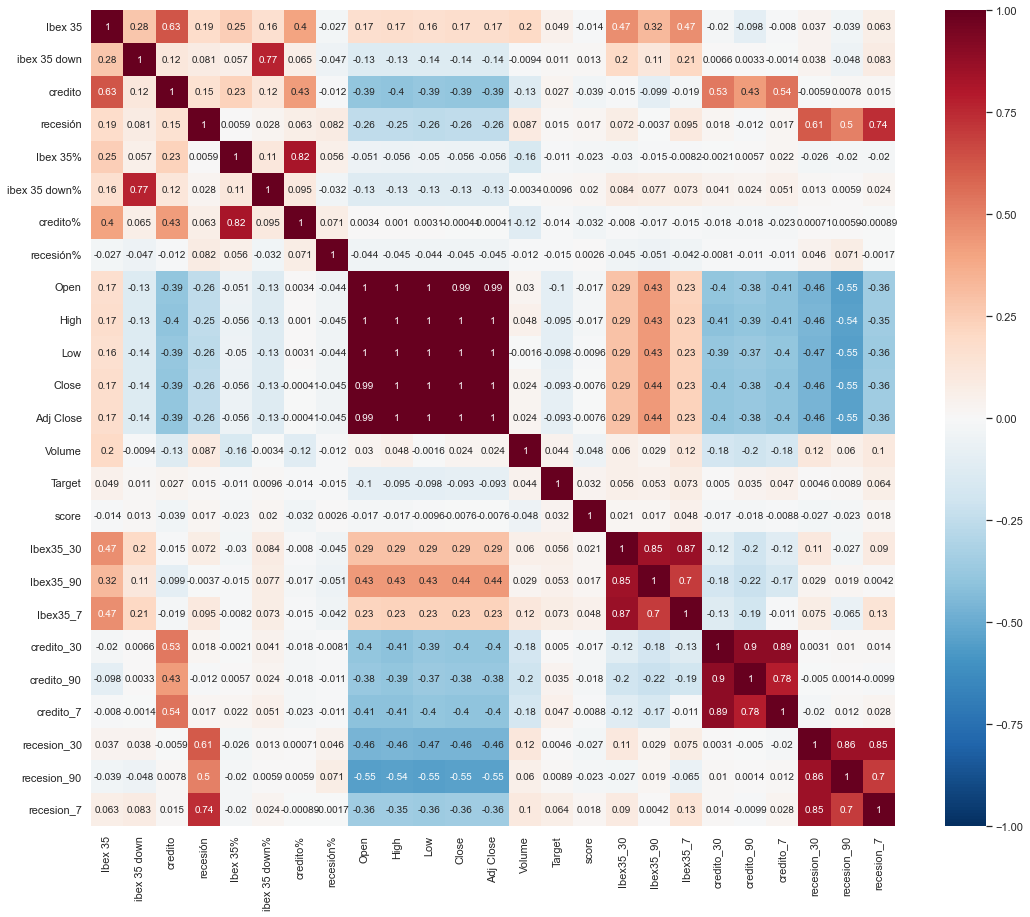

In [21]:
correlation = df_global.corr()
#display(correlation)
plt.figure(figsize=(18,15))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

# MODEL

In [53]:
df_pred_FE.to_numpy().shape

(726, 24)

In [29]:
target = 'Target'
df_global_FE = df_global.fillna(0)
y = df_global_FE[target].to_numpy()
X = df_global_FE.drop(target, axis = 1)[COLS].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

25
24


In [30]:

# fit model no training data
model_012 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=0.8,
    seed=27
)

model_012.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [31]:
# make predictions for train data
y_pred = model_012.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1646
         1.0       1.00      1.00      1.00       498

    accuracy                           1.00      2144
   macro avg       1.00      1.00      1.00      2144
weighted avg       1.00      1.00      1.00      2144



In [32]:
# make predictions for test data
y_pred = model_012.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       706
         1.0       0.70      0.66      0.68       213

    accuracy                           0.86       919
   macro avg       0.80      0.79      0.79       919
weighted avg       0.85      0.86      0.85       919



In [58]:
y_pred = model_012.predict(df_pred_FE.to_numpy())
predictions = [round(value) for value in y_pred]
predictions.count(0), predictions.count(1)

(25, 701)

## TEEST 3

In [40]:
target = 'Target'
y = df_pred_FE[target].to_numpy()
X = df_pred_FE.drop(target, axis = 1)[COLS].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

25
24


In [41]:

# fit model no training data
model_012 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=0.8,
    seed=27
)

model_012.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [42]:
# make predictions for train data
y_pred = model_012.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       344
         1.0       1.00      1.00      1.00       402

    accuracy                           1.00       746
   macro avg       1.00      1.00      1.00       746
weighted avg       1.00      1.00      1.00       746



In [43]:
# make predictions for test data
y_pred = model_012.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66       148
         1.0       0.71      0.75      0.73       173

    accuracy                           0.70       321
   macro avg       0.70      0.69      0.69       321
weighted avg       0.70      0.70      0.70       321



In [ ]:
y_pred = model_012.predict(df_pred_FE.to_numpy())
predictions = [round(value) for value in y_pred]
predictions.count(0), predictions.count(1)

## TEST REAL DATA

In [126]:
df.head(2)
df.columns

Ibex 35  ibex 35 down  credito  recesión  Ibex 35%  ibex 35 down%  \
2015-01-05       65             0       92        11    712.41            0.0   
2015-01-06       55             0       89        36    -15.38            0.0   

            credito%  recesión%          Open          High  ...     score  \
2015-01-05     76.92     -35.29  10267.200195  10390.799805  ... -0.213600   
2015-01-06     -3.26     227.25  10040.700195  10060.799805  ...  0.395567   

            Ibex35_30  Ibex35_90  Ibex35_7  credito_30  credito_90  credito_7  \
2015-01-05     2090.0     6056.0     443.0      2511.0      8012.0      524.0   
2015-01-06     2086.0     6049.0     424.0      2513.0      8018.0      536.0   

            recesion_30  recesion_90  recesion_7  
2015-01-05        509.0       1418.0       176.0  
2015-01-06        526.0       1446.0       208.0  

[2 rows x 25 columns]

In [145]:
df_stock_test

test_index        Date         Open         High          Low  \
0          6557  2019-06-05  9136.799805  9173.400391  9095.000000   
1          6558  2019-06-06  9169.200195  9246.200195  9136.700195   
2          6559  2019-06-07  9186.700195  9261.400391  9185.700195   
3          6560  2019-06-10  9284.200195  9302.200195  9248.099609   
4          6561  2019-06-11  9288.599609  9332.500000  9273.400391   
..          ...         ...          ...          ...          ...   
721        7278  2022-03-25  8314.099609  8363.200195  8286.500000   
722        7279  2022-03-28  8354.400391  8485.700195  8354.400391   
723        7280  2022-03-29  8451.000000  8621.000000  8419.700195   
724        7281  2022-03-30  8583.299805  8597.400391  8508.900391   
725        7282  2022-03-31  8562.599609  8588.299805  8445.099609   

           Close    Adj Close       Volume  
0    9150.500000  9150.500000  158753000.0  
1    9169.200195  9169.200195  212720900.0  
2    9236.099609  9236.099609  150664700.0  
3    9294.099609  9294.099609  102323700.0  
4    9282.099609  9282.099609  144701200.0  
..           ...          ...          ...  
721  8330.599609  8330.599609  156189000.0  
722  8365.599609  8365.599609  167961800.0  
723  8614.599609  8614.599609  257812200.0  
724  8550.599609  8550.599609  185389000.0  
725  8445.099609  8445.099609  220117500.0  

[726 rows x 8 columns]

In [188]:
df_pred = df_stock_test.set_index('date').join(df_pytrends.set_index('Date'))
df_pred = df_pred.join(df_tweets_score.set_index('date'))
df_pred = df_pred[~df_pred.index.duplicated(keep='first')]#[~df_pred.index.duplicated(keep='first')]
df_pred 

Ibex 35  ibex 35 down  credito  recesión  Ibex 35%  ibex 35 down%  \
2014-06-05       68             0       89        28     -4.23            0.0   
2014-06-06       79             0       88         8     16.18            0.0   
2014-06-07       15             0       60        15    -81.01            0.0   
2014-06-08       15             0       48        20      0.00            0.0   
2014-06-09       84             0       88        20    459.97            0.0   
...             ...           ...      ...       ...       ...            ...   
2022-05-22        6             0       54        10    -14.28            0.0   
2022-05-23       68             0       88        16   1033.16            0.0   
2022-05-24       71            66       90        16      4.41      6600000.0   
2022-05-25       64             0       86        19     -9.86         -100.0   
2022-05-26        0             0        0         0   -100.00            0.0   

            credito%  recesión%  test_index  Open  High  Low  Close  \
2014-06-05      0.00      -9.68         NaN   NaN   NaN  NaN    NaN   
2014-06-06     -1.12     -71.43         NaN   NaN   NaN  NaN    NaN   
2014-06-07    -31.82      87.49         NaN   NaN   NaN  NaN    NaN   
2014-06-08    -20.00      33.33         NaN   NaN   NaN  NaN    NaN   
2014-06-09     83.33       0.00         NaN   NaN   NaN  NaN    NaN   
...              ...        ...         ...   ...   ...  ...    ...   
2022-05-22    -19.40     -47.37         NaN   NaN   NaN  NaN    NaN   
2022-05-23     62.96      59.99         NaN   NaN   NaN  NaN    NaN   
2022-05-24      2.27       0.00         NaN   NaN   NaN  NaN    NaN   
2022-05-25     -4.44      18.75         NaN   NaN   NaN  NaN    NaN   
2022-05-26   -100.00     -99.99         NaN   NaN   NaN  NaN    NaN   

            Adj Close  Volume  score  
2014-06-05        NaN     NaN    NaN  
2014-06-06        NaN     NaN    NaN  
2014-06-07        NaN     NaN    NaN  
2014-06-08        NaN     NaN    NaN  
2014-06-09        NaN     NaN    NaN  
...               ...     ...    ...  
2022-05-22        NaN     NaN    NaN  
2022-05-23        NaN     NaN    NaN  
2022-05-24        NaN     NaN    NaN  
2022-05-25        NaN     NaN    NaN  
2022-05-26        NaN     NaN    NaN  

[2913 rows x 16 columns]

In [180]:
df_pytrends.drop_duplicates()

date  Ibex 35  ibex 35 down  credito  recesión  Ibex 35%  \
0     2014-06-05       68             0       89        28     -4.23   
1     2014-06-06       79             0       88         8     16.18   
2     2014-06-07       15             0       60        15    -81.01   
3     2014-06-08       15             0       48        20      0.00   
4     2014-06-09       84             0       88        20    459.97   
...          ...      ...           ...      ...       ...       ...   
3058  2022-05-22        6             0       54        10    -14.28   
3059  2022-05-23       68             0       88        16   1033.16   
3060  2022-05-24       71            66       90        16      4.41   
3061  2022-05-25       64             0       86        19     -9.86   
3062  2022-05-26        0             0        0         0   -100.00   

      ibex 35 down%  credito%  recesión%  
0               0.0      0.00      -9.68  
1               0.0     -1.12     -71.43  
2               0.0    -31.82      87.49  
3               0.0    -20.00      33.33  
4               0.0     83.33       0.00  
...             ...       ...        ...  
3058            0.0    -19.40     -47.37  
3059            0.0     62.96      59.99  
3060      6600000.0      2.27       0.00  
3061         -100.0     -4.44      18.75  
3062            0.0   -100.00     -99.99  

[3001 rows x 9 columns]

In [160]:
df_pred = df_pred.apply(pd.to_numeric, errors='coerce')
df_pred = df_pred.dropna()
df_pred.index #in df_stock_test.Date
df_pred[df_pred.index.isin(list(df_stock_test.Date))]
len(pd.unique(df_pred.index))


702

In [132]:
df_pred.index

Index(['2019-06-05', '2019-06-06', '2019-06-07', '2019-06-10', '2019-06-11',
       '2019-06-12', '2019-06-13', '2019-06-14', '2019-06-17', '2019-06-18',
       ...
       '2022-03-15', '2022-03-16', '2022-03-18', '2022-03-21', '2022-03-22',
       '2022-03-23', '2022-03-25', '2022-03-28', '2022-03-30', '2022-03-31'],
      dtype='object', length=747)

In [133]:
df_stock_test.index

RangeIndex(start=0, stop=726, step=1)

### EDA

/usr/local/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


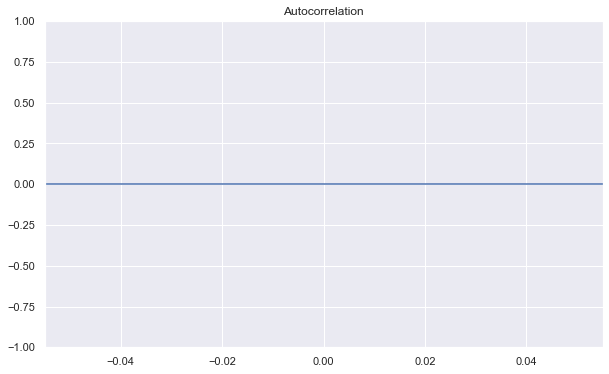

In [90]:
plt.rc("figure", figsize=(10,6))
sm.graphics.tsa.plot_acf(df_stock.Close);

In [91]:
#drawing one figure with title and 3 axes below each other. Size and resolution are specified
f, axes = plt.subplots(3,1,figsize=(18,12),dpi=600,sharex=True)
plt.suptitle('Comparison of unscaled features at different scales',fontsize=22);

#drawing boxplots of three different scales, each to separate axis
sns.boxplot(data=df_stock.iloc[:,1:26], ax=axes[0])
sns.boxplot(data=df_stock.iloc[:,1:26], ax=axes[1]).set(ylim=(-15,50))
sns.boxplot(data=df_stock.iloc[:,1:26], ax=axes[2]).set(ylim=(-10,10))

#rotating ticks of the shared x axis by 90 degrees. The shared x axis is located on axes[2]
for tick in axes[2].get_xticklabels():
        tick.set_rotation(90);

#setting y axis labels for each axis
for a in axes:
    a.set_ylabel('Unscaled values');

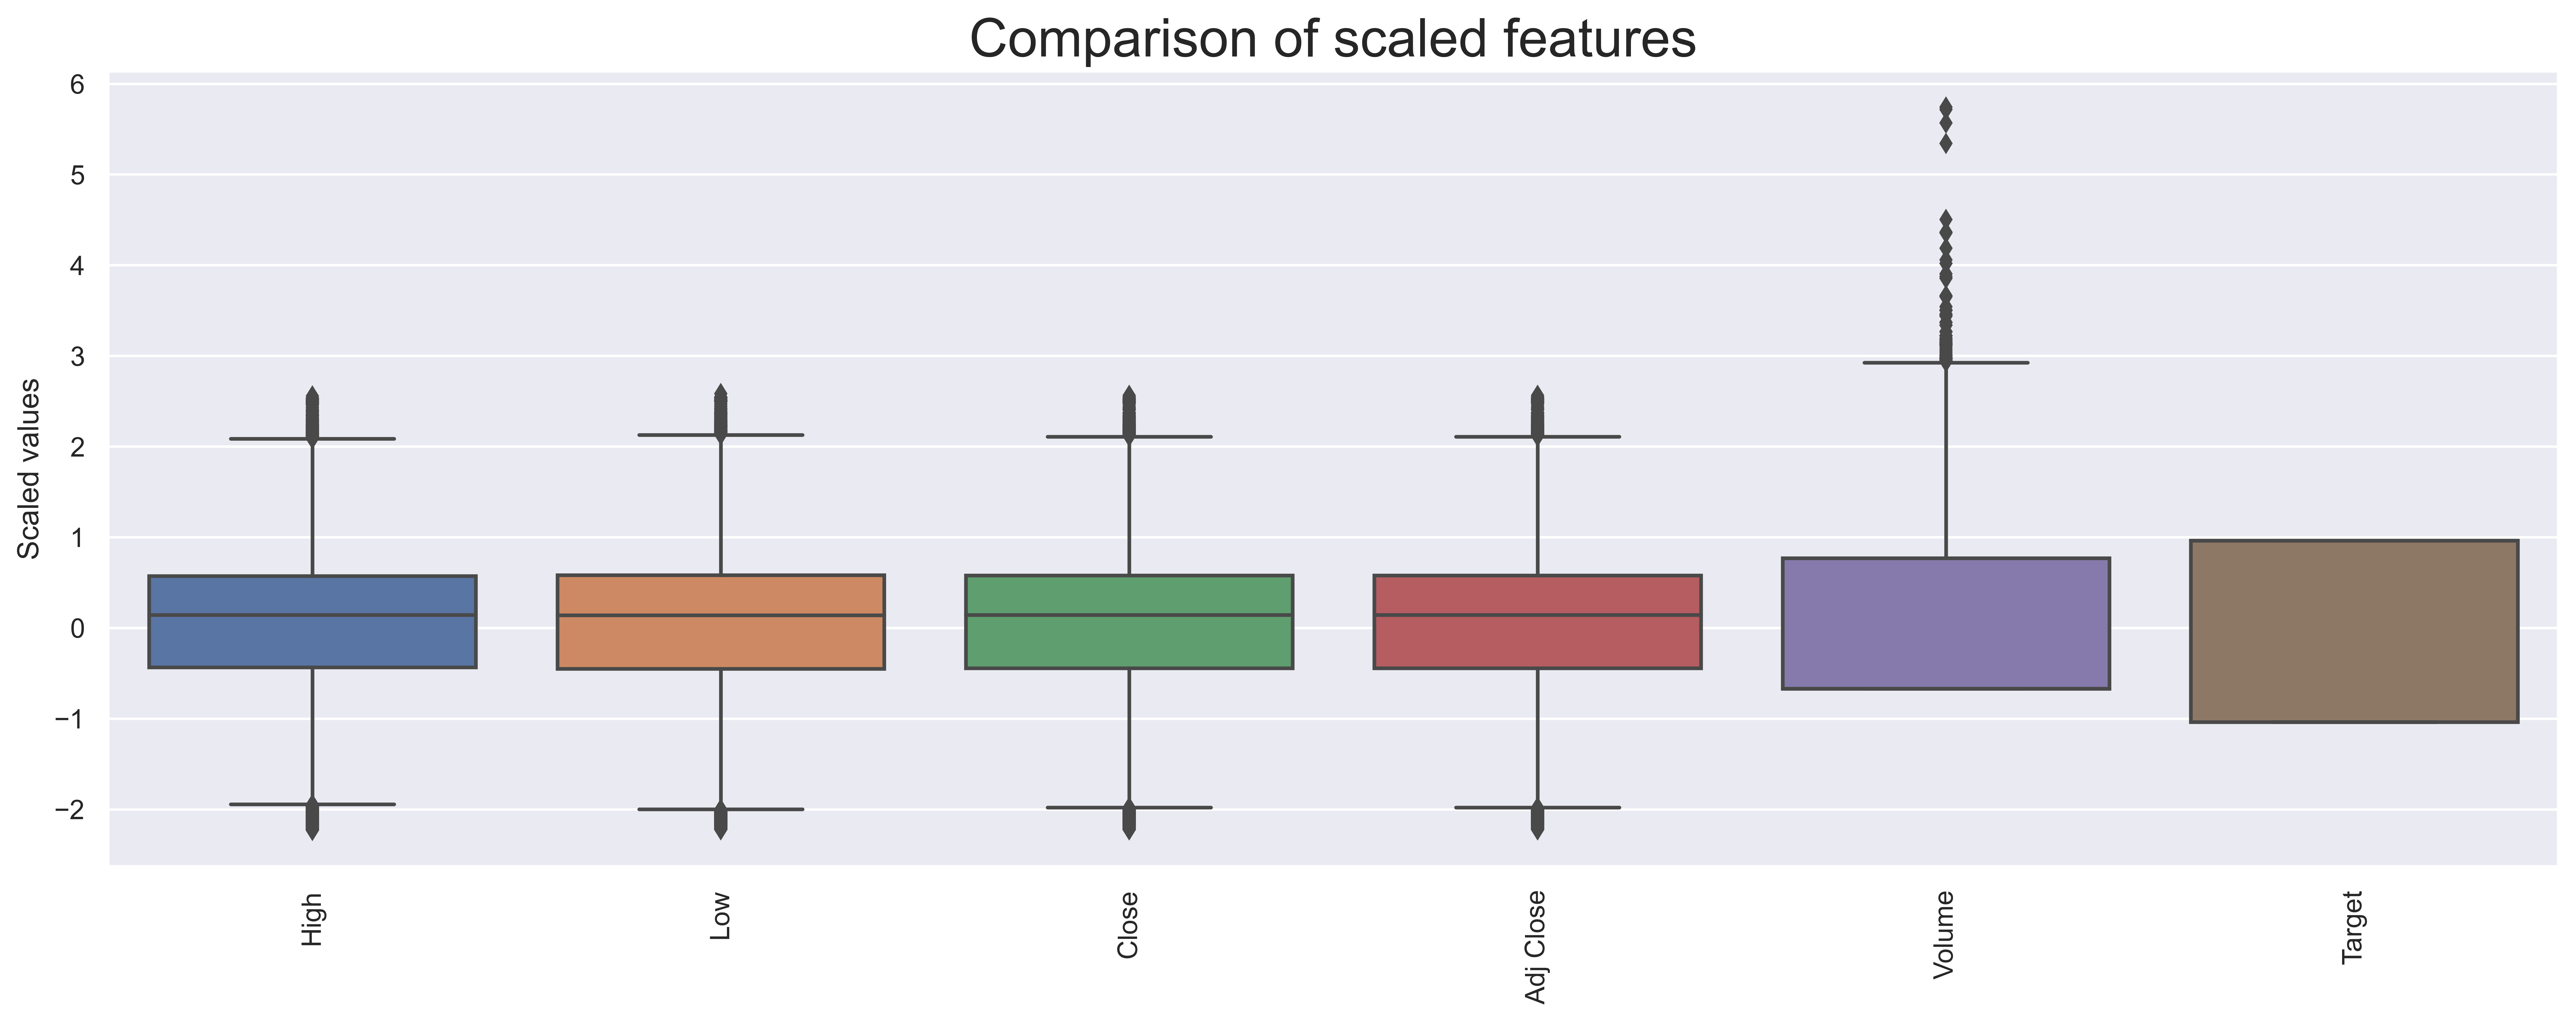

In [92]:
#creating new dataframe for scaled feature values by first copying the original dataframe
df_features_scaled = df_stock.iloc[:,2:26].copy()

#substituting unscaled feature values by scaled values using sklearn StandardScaler
scaler = StandardScaler()
df_features_scaled.iloc[:,:] = scaler.fit_transform(df_features_scaled.iloc[:,:])

#drawing figure with title and single axis. Size and resolution are specified
plt.figure(figsize=(18,6),dpi=600);
plt.title('Comparison of scaled features',fontsize=22);

#setting y axis label
plt.ylabel('Scaled values');

#rotating x axis ticks by 90 degrees
plt.xticks(rotation=90);

#drawing boxplot of scaled feature values
sns.boxplot(data=df_features_scaled);

## MODELS

In [12]:
df_global.columns
df = df_global[['credito','close','volume','Ibex 35']]
df['date'] = df.index
df.index = [x for x in range(df.shape[0])]
df['index'] =df.index.astype(np.int64)
df

/var/folders/r7/669zllp50w3dt5hksf5_4bsw0000gn/T/ipykernel_13878/4065548797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/var/folders/r7/669zllp50w3dt5hksf5_4bsw0000gn/T/ipykernel_13878/4065548797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] =df.index.astype(np.int64)


credito         close       volume  Ibex 35        date  index
0          60           NaN          NaN        6  2017-04-29      0
1          48           NaN          NaN        3  2017-04-30      1
2          53           NaN          NaN       11  2017-05-01      2
3          89  10820.299805  225313300.0       52  2017-05-02      3
4          89  10837.000000  192962800.0       53  2017-05-03      4
...       ...           ...          ...      ...         ...    ...
1938       67           NaN          NaN        7  2022-05-21   1938
1939       54           NaN          NaN        6  2022-05-22   1939
1940       88   8625.799805  166876400.0       67  2022-05-23   1940
1941       90   8631.200195  207033000.0       72  2022-05-24   1941
1942        0   8760.200195  203488200.0        0  2022-05-25   1942

[1943 rows x 6 columns]

https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

https://github.com/jdb78/pytorch-forecasting

In [13]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

agency     sku     volume       date  industry_volume  soda_volume  \
291    Agency_25  SKU_03     0.5076 2013-01-01        492612703    718394219   
871    Agency_29  SKU_02     8.7480 2015-01-01        498567142    762225057   
19532  Agency_47  SKU_01     4.9680 2013-09-01        454252482    789624076   
2089   Agency_53  SKU_07    21.6825 2013-10-01        480693900    791658684   
9755   Agency_17  SKU_02   960.5520 2015-03-01        515468092    871204688   
7561   Agency_05  SKU_03  1184.6535 2014-02-01        425528909    734443953   
19204  Agency_11  SKU_05     5.5593 2017-08-01        623319783   1049868815   
8781   Agency_48  SKU_04  4275.1605 2013-03-01        509281531    892192092   
2540   Agency_07  SKU_21     0.0000 2015-10-01        544203593    761469815   
12084  Agency_21  SKU_03    46.3608 2017-04-01        589969396    940912941   

       avg_max_temp  price_regular  price_actual    discount  ...  \
291       25.845238    1264.162234   1152.473405  111.688829  ...   
871       27.584615    1316.098485   1296.804924   19.293561  ...   
19532     30.665957    1269.250000   1266.490490    2.759510  ...   
2089      29.197727    1193.842373   1128.124395   65.717978  ...   
9755      23.608120    1338.334248   1232.128069  106.206179  ...   
7561      28.668254    1369.556376   1161.135214  208.421162  ...   
19204     31.915385    1922.486644   1651.307674  271.178970  ...   
8781      26.767857    1761.258209   1546.059670  215.198539  ...   
2540      28.987755       0.000000      0.000000    0.000000  ...   
12084     32.478910    1675.922116   1413.571789  262.350327  ...   

       football_gold_cup  beer_capital  music_fest discount_in_percent  \
291                    -             -           -            8.835008   
871                    -             -           -            1.465966   
19532                  -             -           -            0.217413   
2089                   -  beer_capital           -            5.504745   
9755                   -             -  music_fest            7.935699   
7561                   -             -           -           15.218151   
19204                  -             -           -           14.105636   
8781                   -             -  music_fest           12.218455   
2540                   -             -           -            0.000000   
12084                  -             -           -           15.654088   

      timeseries time_idx month log_volume avg_volume_by_sku  \
291          228        0     1  -0.678062       1225.306376   
871          177       24     1   2.168825       1634.434615   
19532        322        8     9   1.603017       2625.472644   
2089         240        9    10   3.076505         38.529107   
9755         259       26     3   6.867508       2143.677462   
7561          21       13     2   7.077206       1566.643589   
19204         17       55     8   1.715472       1385.225478   
8781         151        2     3   8.360577       1757.950603   
2540         300       33    10 -18.420681          0.000000   
12084        181       51     4   3.836454       2034.293024   

      avg_volume_by_agency  
291              99.650400  
871              11.397086  
19532            48.295650  
2089           2511.035175  
9755            396.022140  
7561           1881.866367  
19204           109.699200  
8781           1925.272108  
2540           2418.719550  
12084           109.381800  

[10 rows x 31 columns]

In [14]:
data.info()
data.describe()
data.labor_day


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 6650
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-nul

0       -
238     -
237     -
236     -
235     -
       ..
6765    -
6764    -
6763    -
6771    -
6650    -
Name: labor_day, Length: 21000, dtype: category
Categories (2, object): ['-', 'labor_day']

## TEST DATA

In [15]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## REAL DATA

In [ ]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

In [34]:
data

agency     sku     volume       date  industry_volume  soda_volume  \
0     Agency_22  SKU_01    52.2720 2013-01-01        492612703    718394219   
238   Agency_37  SKU_04     0.0000 2013-01-01        492612703    718394219   
237   Agency_59  SKU_03   812.9214 2013-01-01        492612703    718394219   
236   Agency_11  SKU_01   316.4400 2013-01-01        492612703    718394219   
235   Agency_05  SKU_05   420.9093 2013-01-01        492612703    718394219   
...         ...     ...        ...        ...              ...          ...   
6765  Agency_08  SKU_03     9.8136 2017-12-01        618073219    919709619   
6764  Agency_60  SKU_05  2235.3495 2017-12-01        618073219    919709619   
6763  Agency_19  SKU_05    87.5430 2017-12-01        618073219    919709619   
6771  Agency_60  SKU_03   325.8792 2017-12-01        618073219    919709619   
6650  Agency_56  SKU_01  3283.8480 2017-12-01        618073219    919709619   

      avg_max_temp  price_regular  price_actual    discount  ...  \
0        25.845238    1168.903668   1069.166193   99.737475  ...   
238      26.505000    1852.273642   1611.466298  240.807344  ...   
237      22.219737    1270.795012   1197.184260   73.610752  ...   
236      25.360000    1176.155397   1082.757488   93.397909  ...   
235      24.079012    1327.003396   1207.822992  119.180404  ...   
...            ...            ...           ...         ...  ...   
6765     25.373665    1706.410263   1455.262060  251.148203  ...   
6764     23.081069    1898.981558   1528.616113  370.365445  ...   
6763     27.432590    1902.160687   1547.299733  354.860954  ...   
6771     23.081069    1704.503815   1444.443913  260.059902  ...   
6650     21.709841    1729.148426   1223.228147  505.920279  ...   

      football_gold_cup  beer_capital music_fest discount_in_percent  \
0                     -             -          -            8.532566   
238                   -             -          -           13.000635   
237                   -             -          -            5.792496   
236                   -             -          -            7.940950   
235                   -             -          -            8.981168   
...                 ...           ...        ...                 ...   
6765                  -             -          -           14.717926   
6764                  -             -          -           19.503372   
6763                  -             -          -           18.655677   
6771                  -             -          -           15.257220   
6650                  -             -          -           29.258349   

     timeseries time_idx month log_volume avg_volume_by_sku  \
0             0        0     1   3.956461       2613.377501   
238           5        0     1 -18.420681       1361.511918   
237           9        0     1   6.700634       1225.306376   
236          14        0     1   5.757134       2613.377501   
235          22        0     1   6.042417       1179.728165   
...         ...      ...   ...        ...               ...   
6765        336       59    12   2.283769       2304.827516   
6764        188       59    12   7.712153       1530.930920   
6763        162       59    12   4.472130       1530.930920   
6771        187       59    12   5.786527       2304.827516   
6650         71       59    12   8.096771       2716.823019   

     avg_volume_by_agency  
0              103.805460  
238              0.549900  
237           2041.909586  
236            125.690220  
235           1638.463500  
...                   ...  
6765            76.037400  
6764          3311.367493  
6763            56.557950  
6771          3311.367493  
6650          3304.106100  

[21000 rows x 31 columns]

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [16]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()


/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

In [17]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/usr/local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/puche99/Desktop/helpers/hackathons/CaixaBank_DS/.lr_find_73016392-4ca6-4c5f-96cb-7bdcab198253.ckpt
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1718: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  rank_zero_warn(


suggested learning rate: 0.01862087136662867


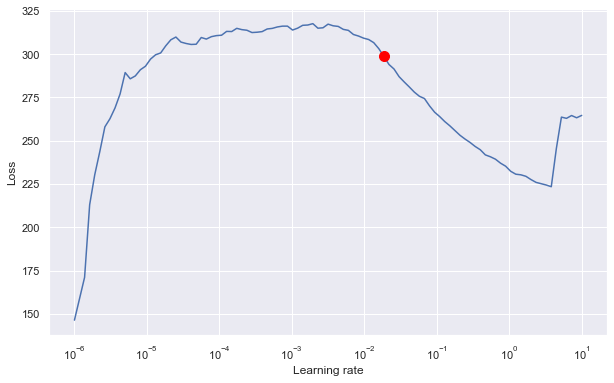

/var/folders/r7/669zllp50w3dt5hksf5_4bsw0000gn/T/ipykernel_13878/450857479.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [18]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [19]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=3,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


In [20]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=2, #200
    max_epochs=3, #50
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-05-28 03:45:00,726] A new study created in memory with name: no-name-d8009078-f6fb-4e66-9512-846f6f3bc958
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `n

{'gradient_clip_val': 0.02826951051724034, 'hidden_size': 66, 'dropout': 0.17289326470182517, 'hidden_continuous_size': 8, 'attention_head_size': 2, 'learning_rate': 0.0010752236342512994}


In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [23]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(384.0892)

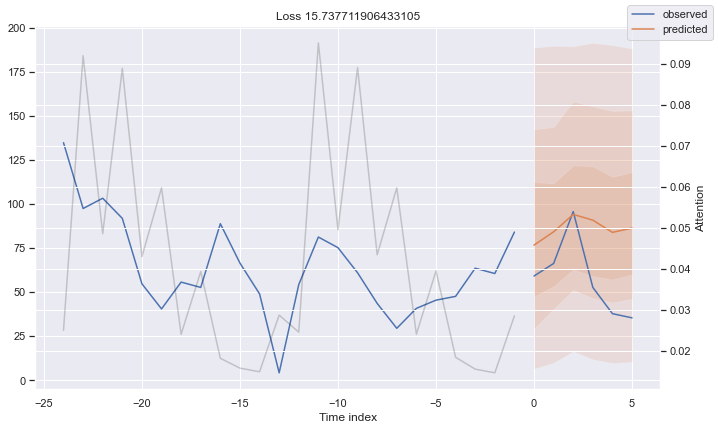

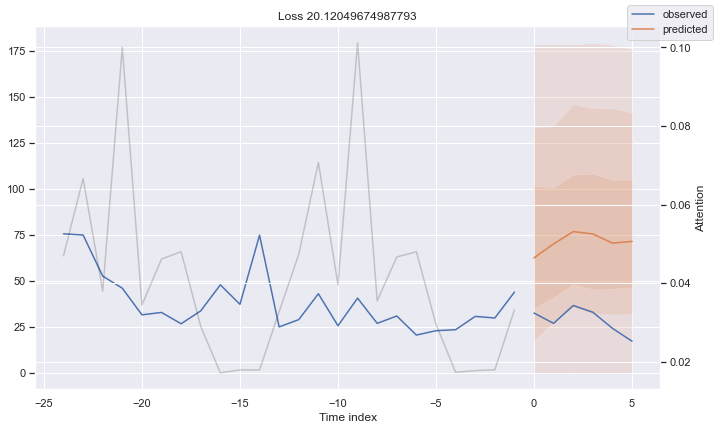

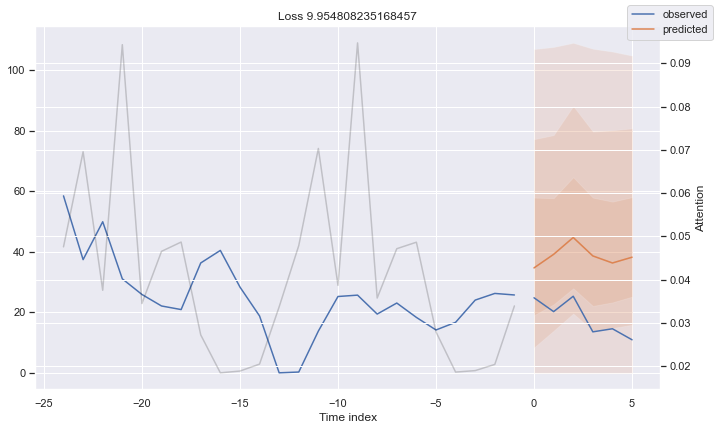

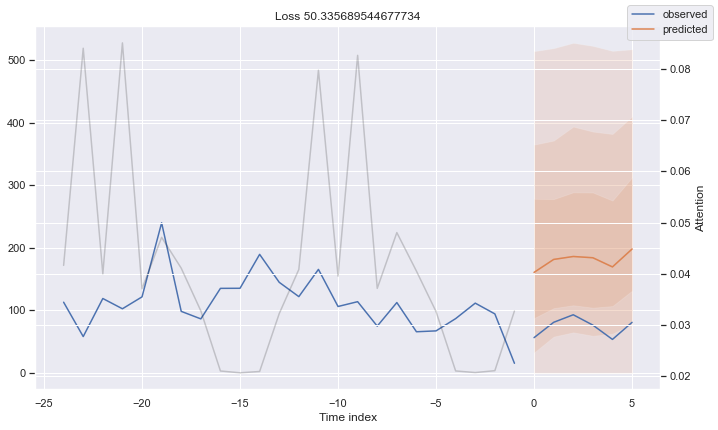

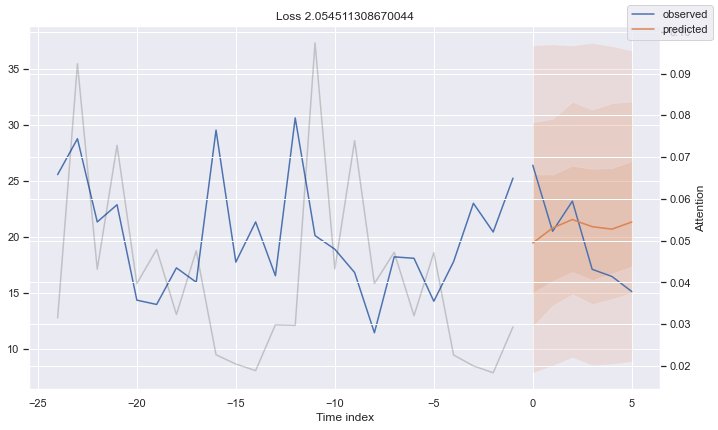

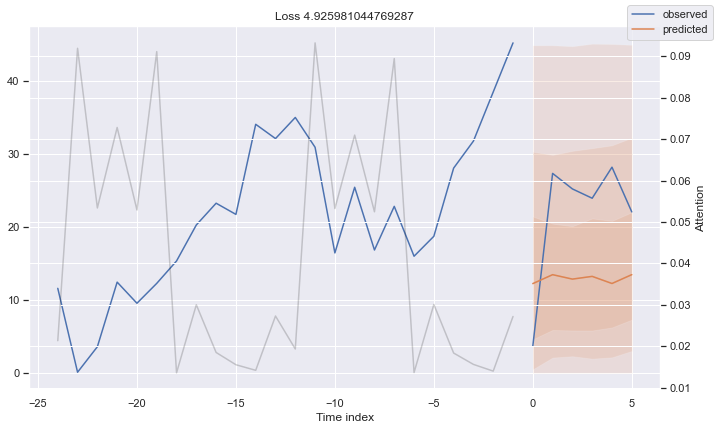

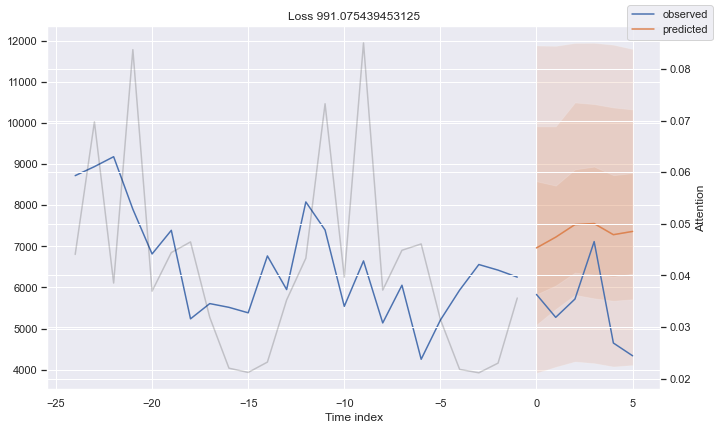

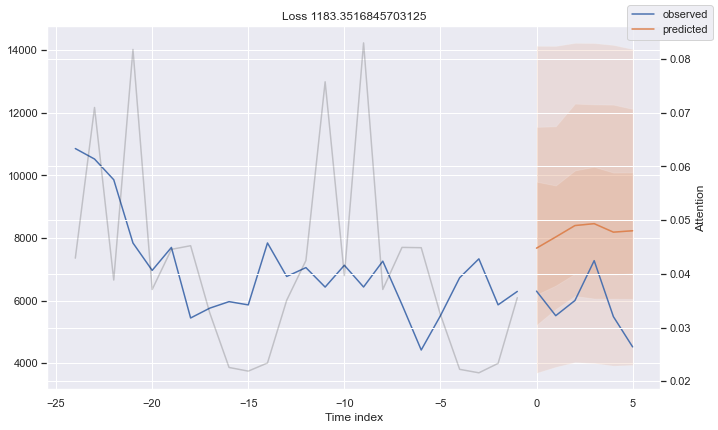

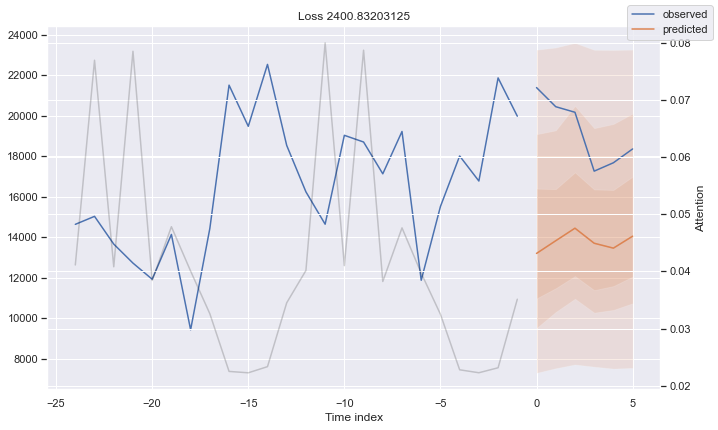

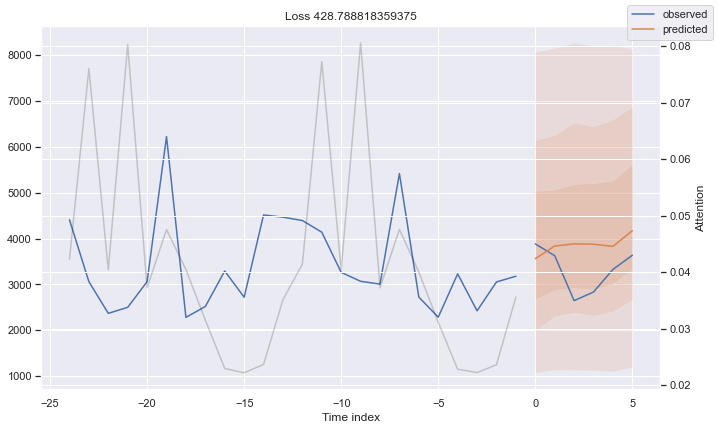

In [24]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

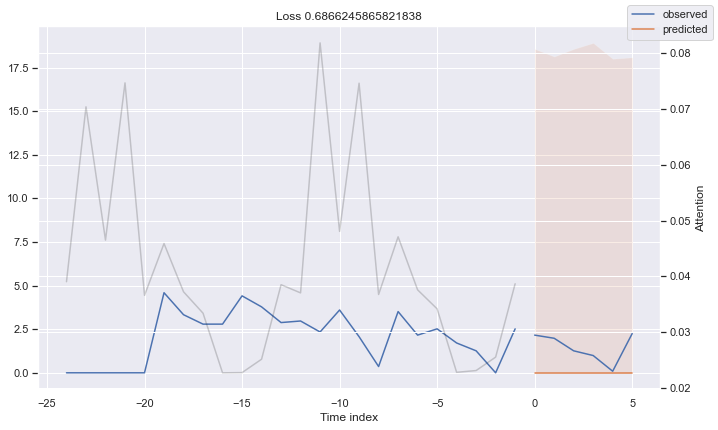

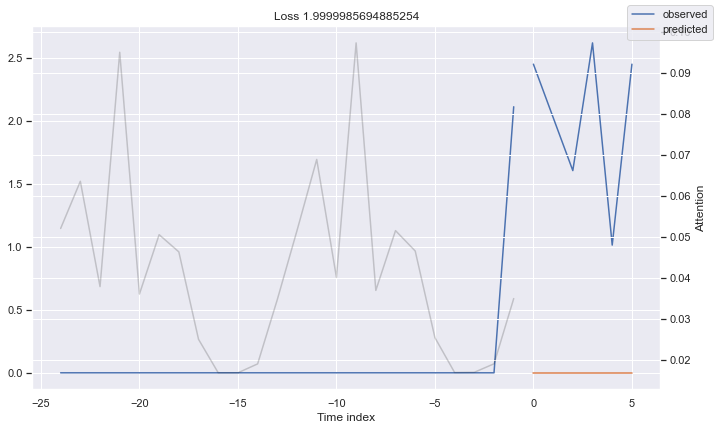

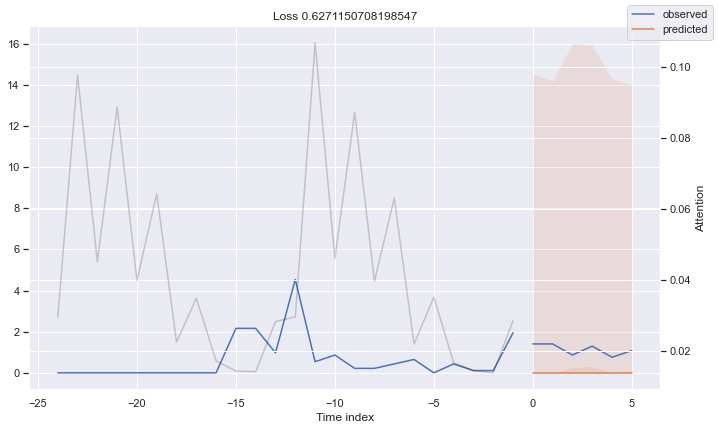

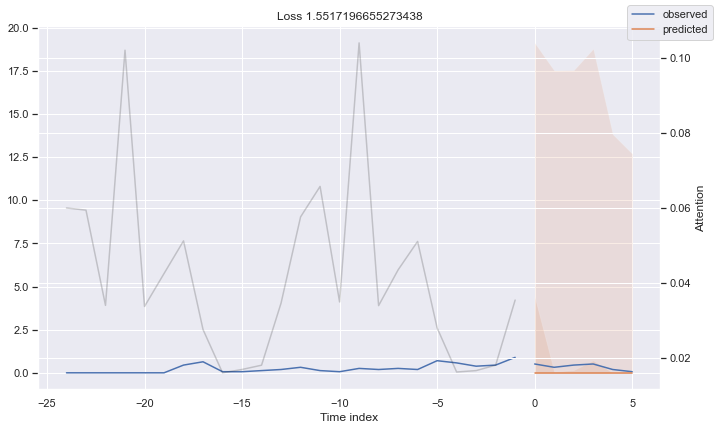

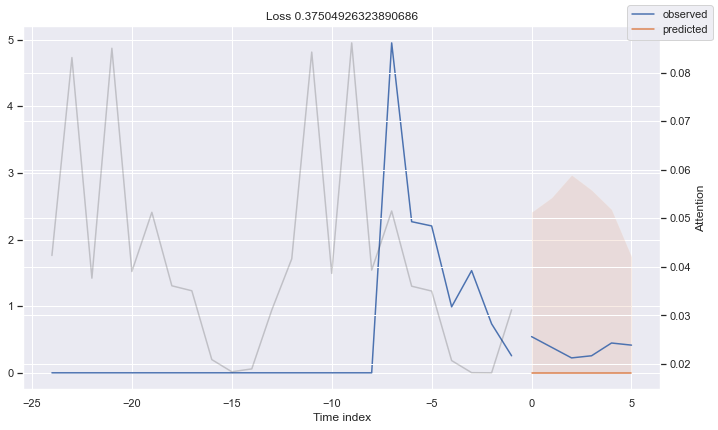

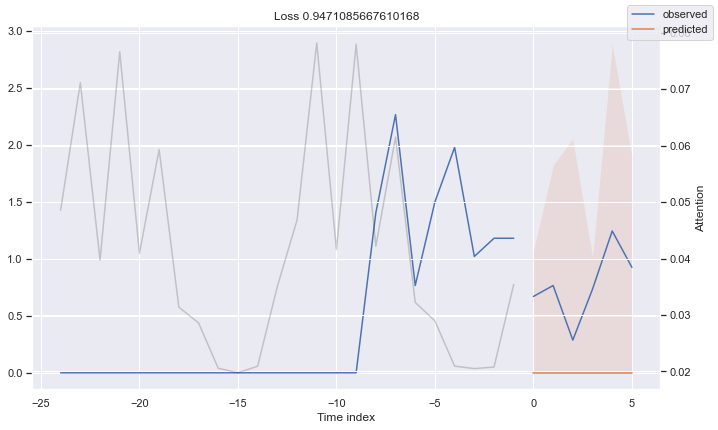

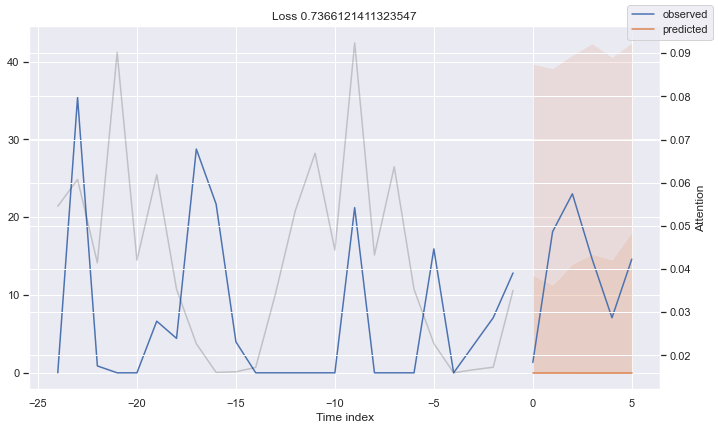

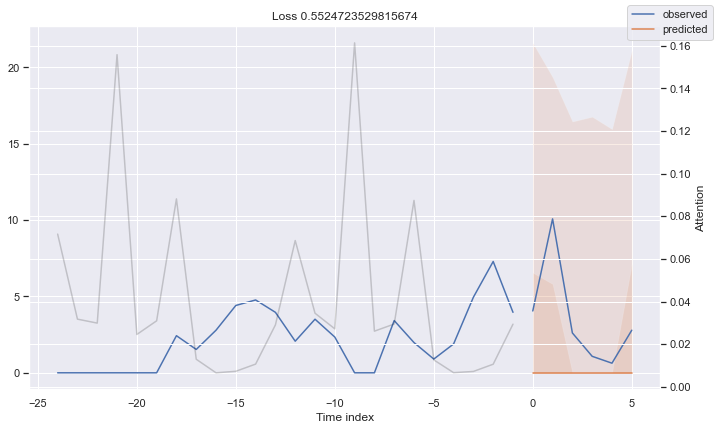

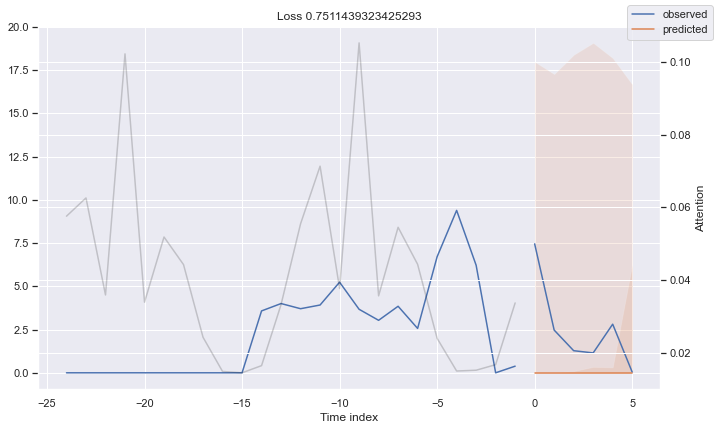

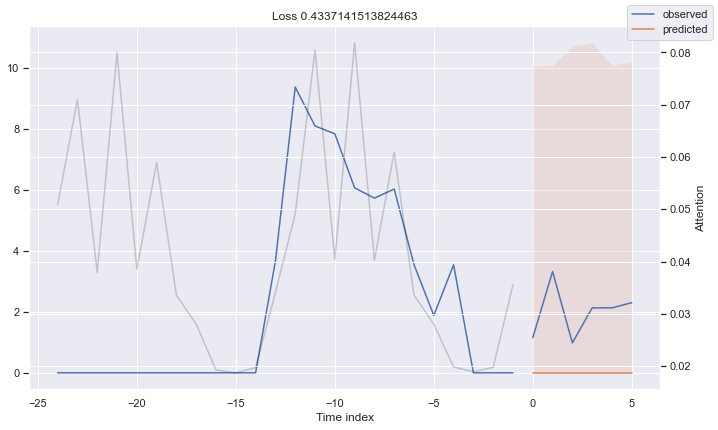

In [25]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

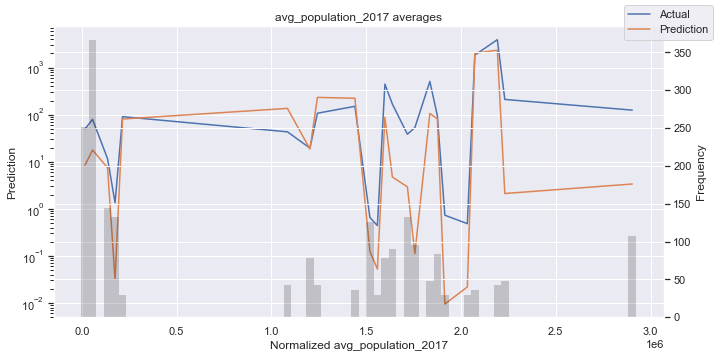

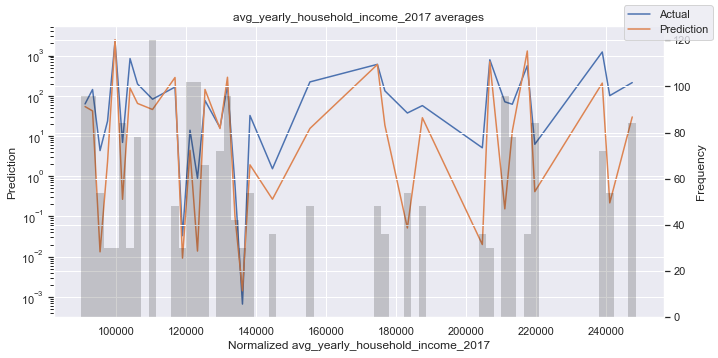

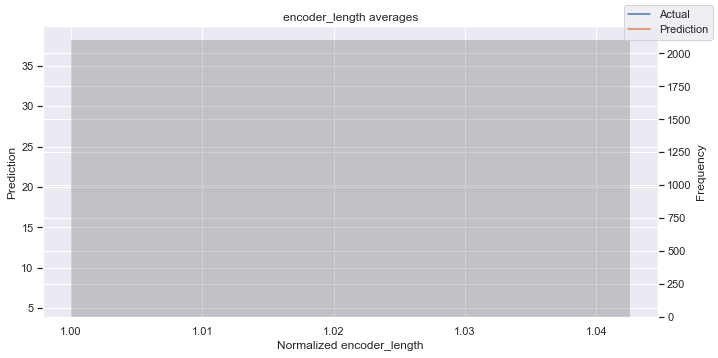

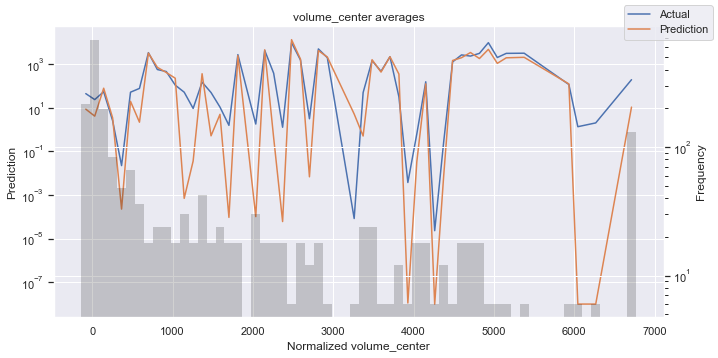

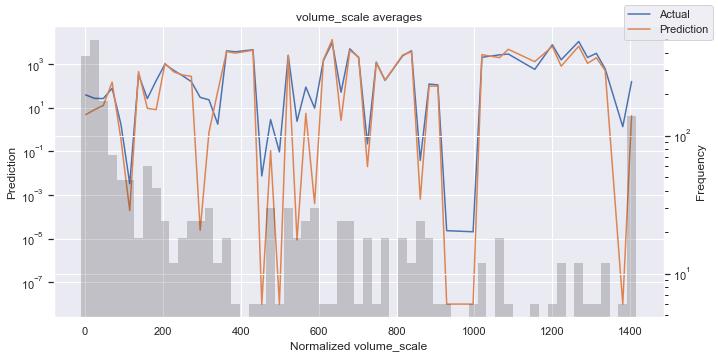

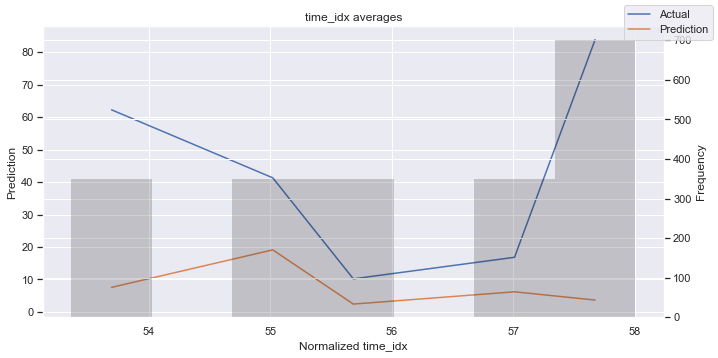

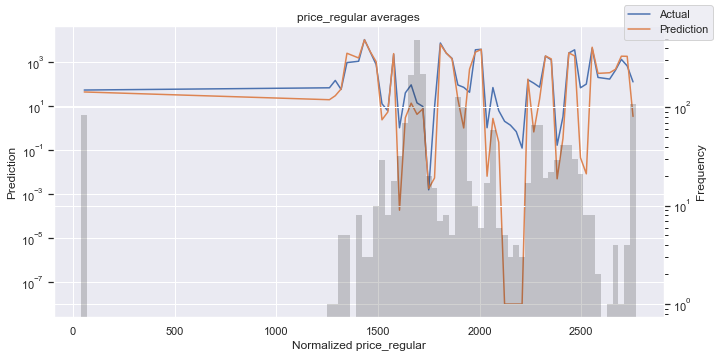

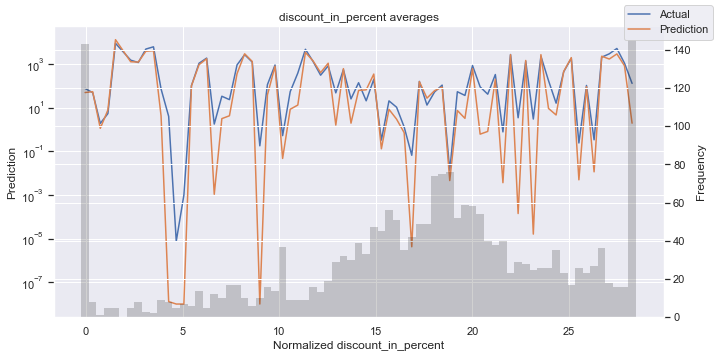

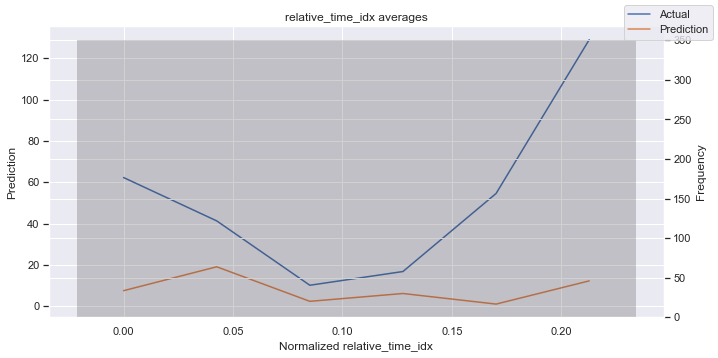

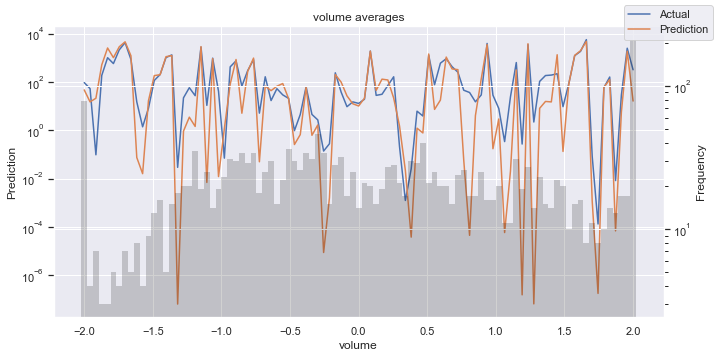

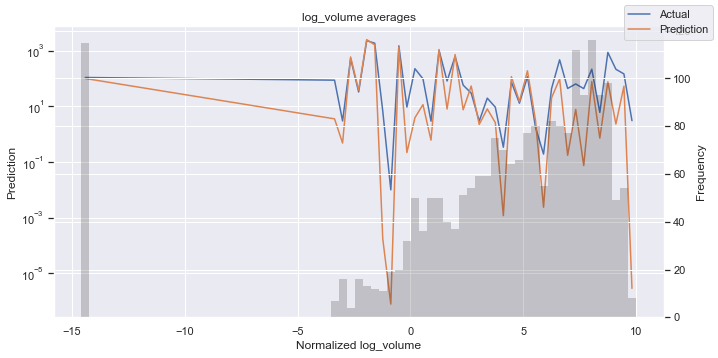

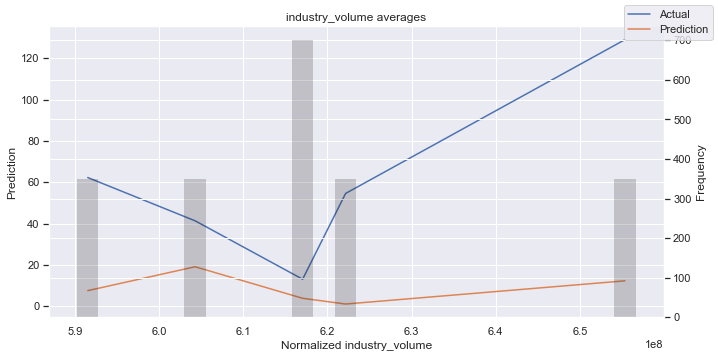

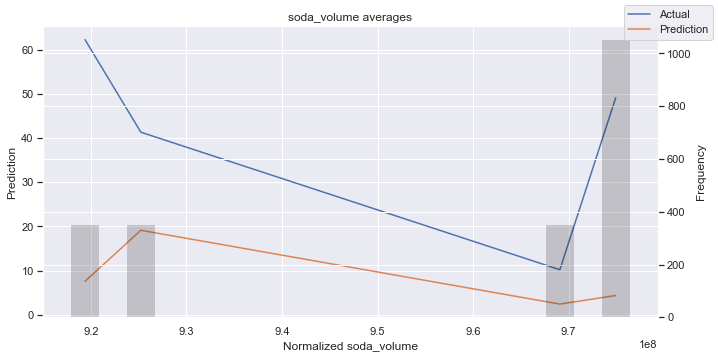

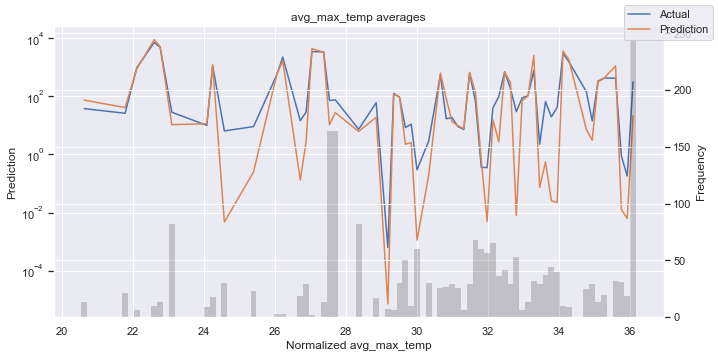

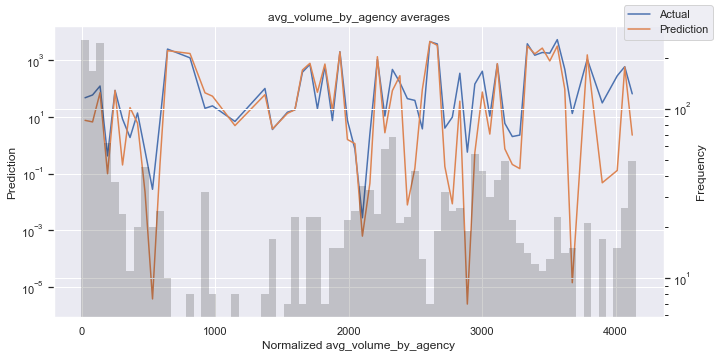

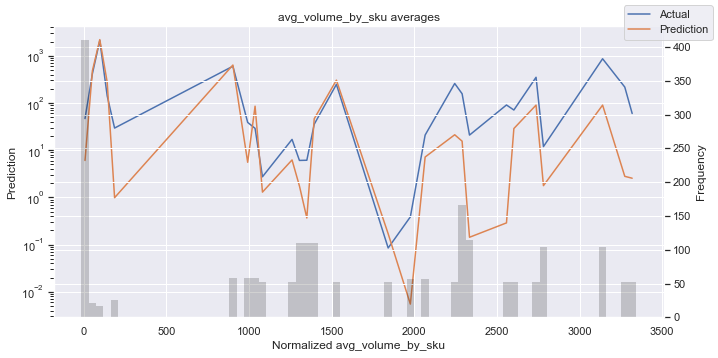

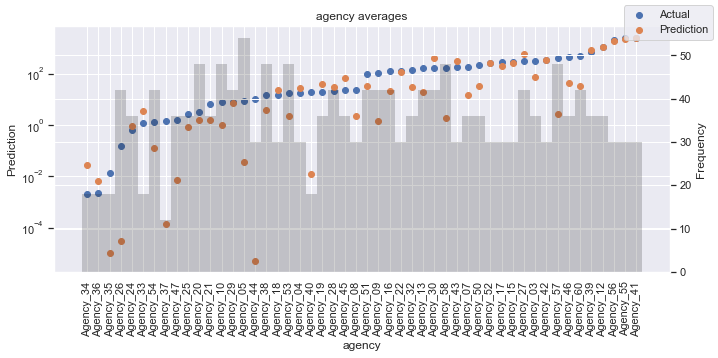

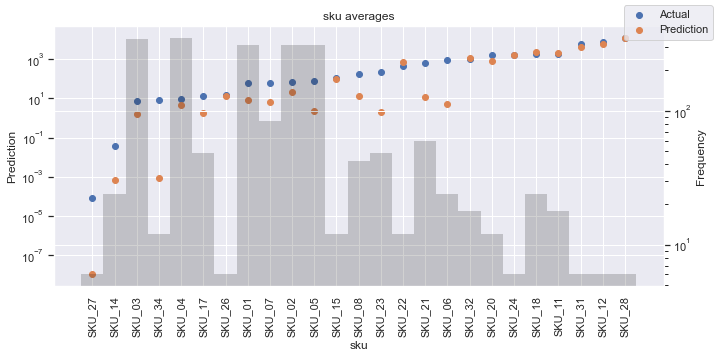

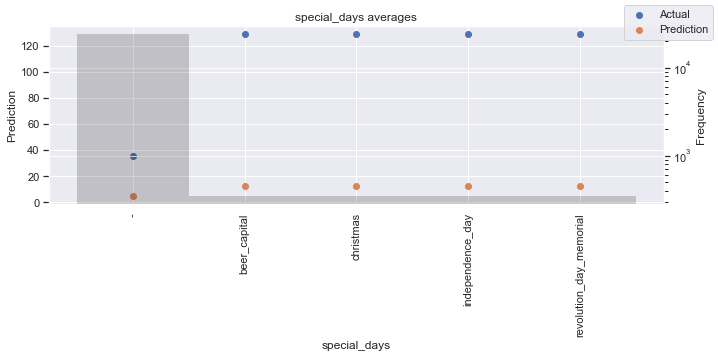

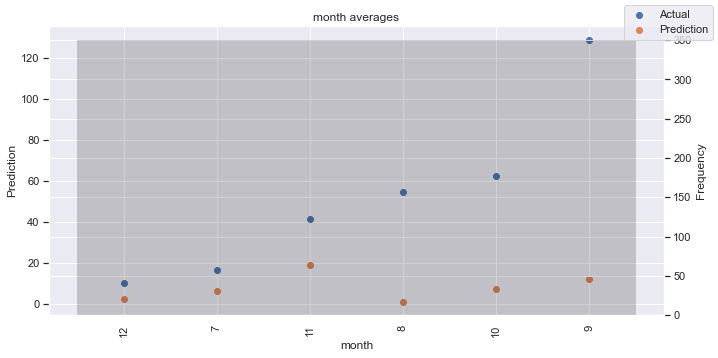

In [26]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [27]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 12.7855,  40.5480,  55.5049,  77.3998, 100.1332, 130.7023, 177.4663],
         [ 19.8680,  43.8682,  55.2045,  79.6656,  94.3783, 126.6129, 169.1015],
         [ 19.7458,  44.7126,  55.7753,  78.4847,  94.3050, 126.8875, 168.4393],
         [ 14.9582,  41.5634,  55.5543,  74.3206,  96.2622, 128.1391, 170.5960],
         [ 18.5306,  49.0137,  59.9590,  77.1563,  92.4990, 124.0319, 167.4599],
         [ 15.2633,  47.9368,  58.7574,  75.5734,  95.2899, 129.5383, 172.9370]]])

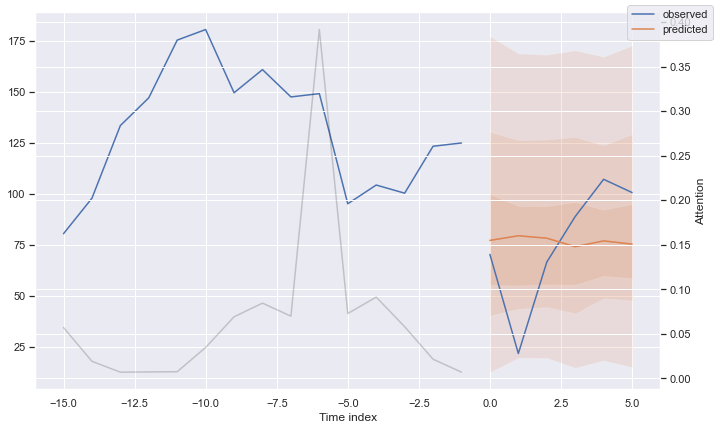

In [28]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [29]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

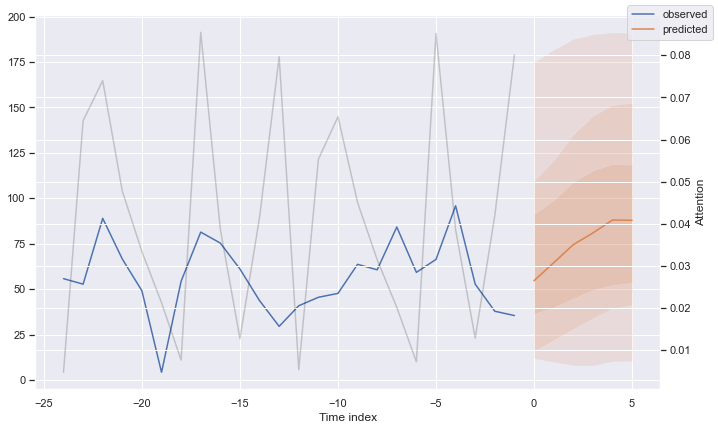

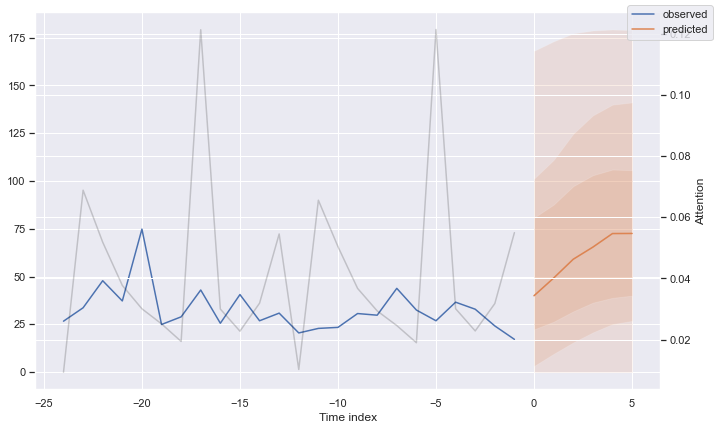

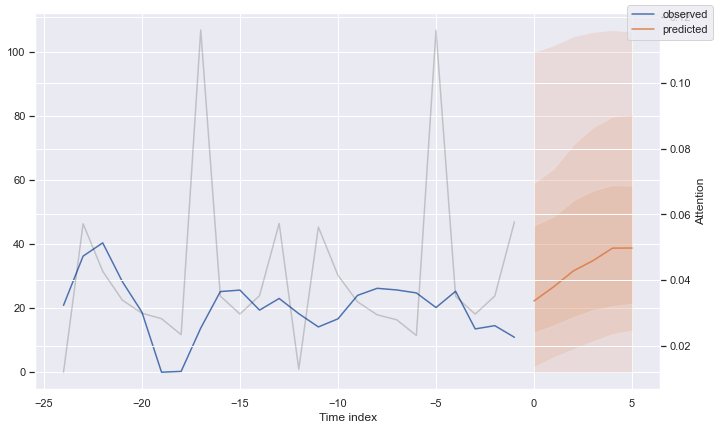

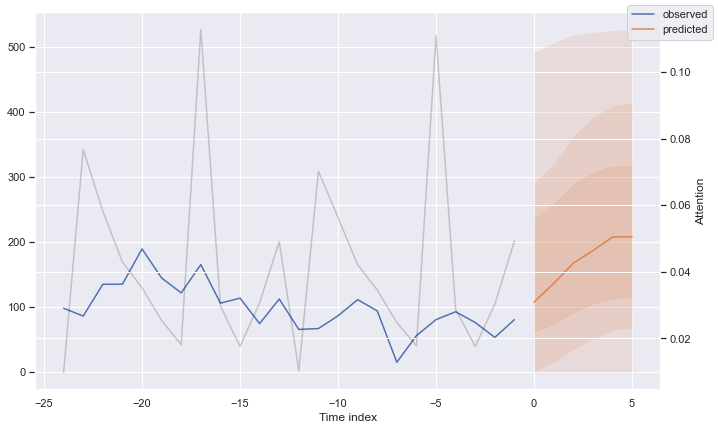

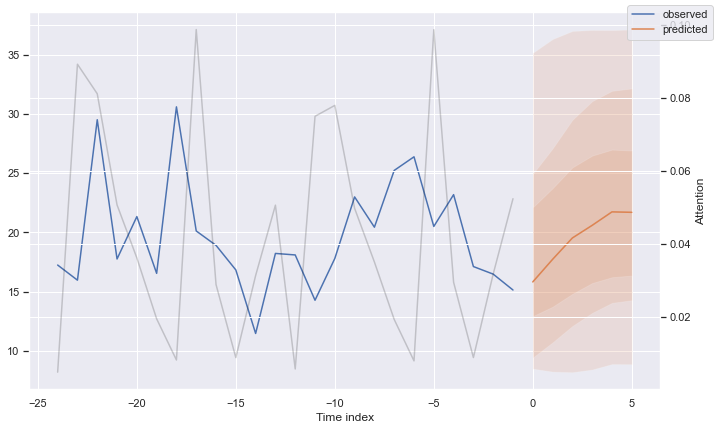

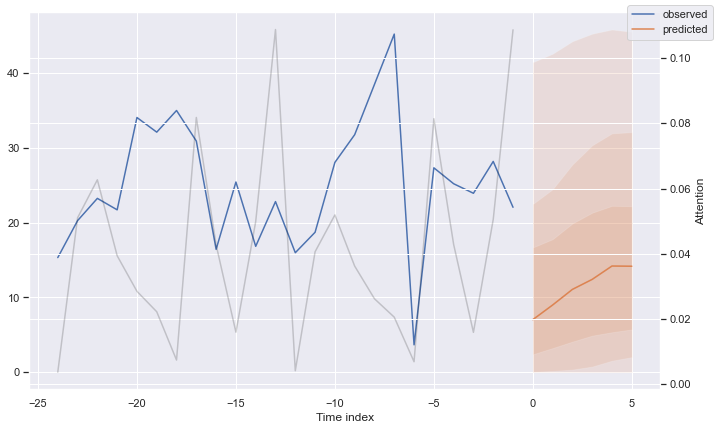

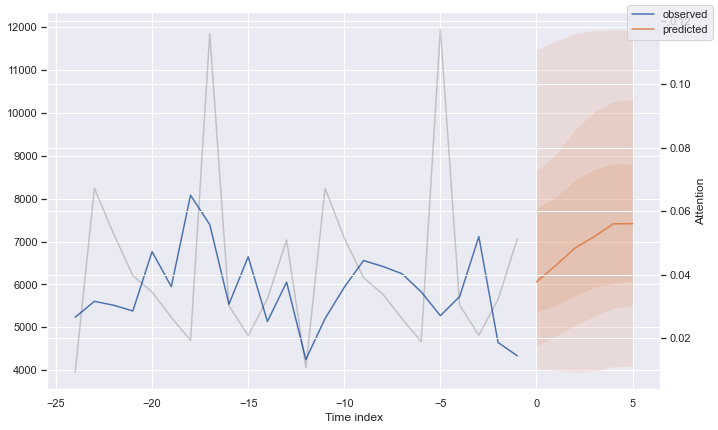

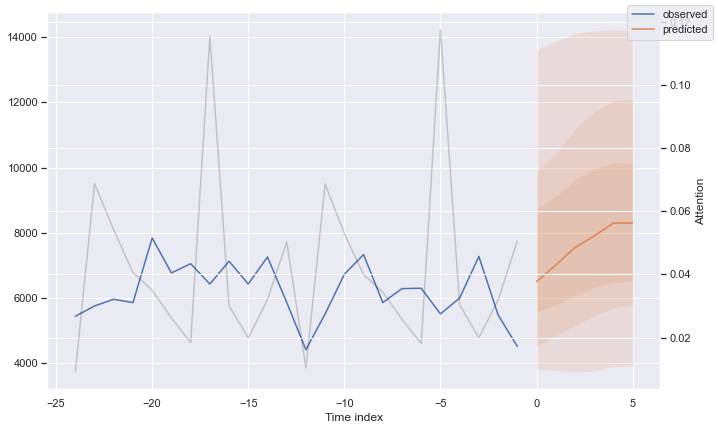

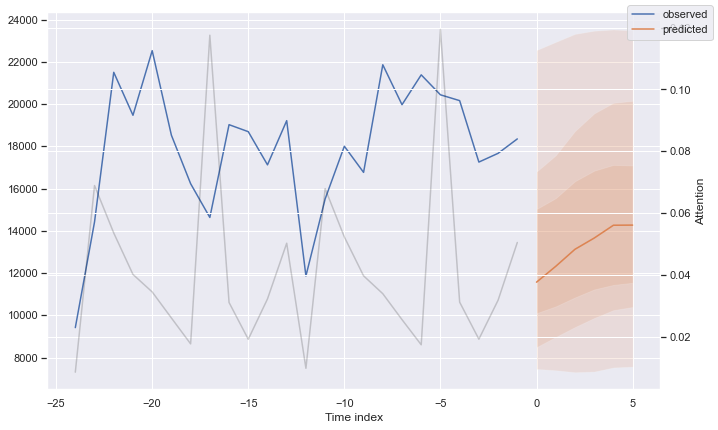

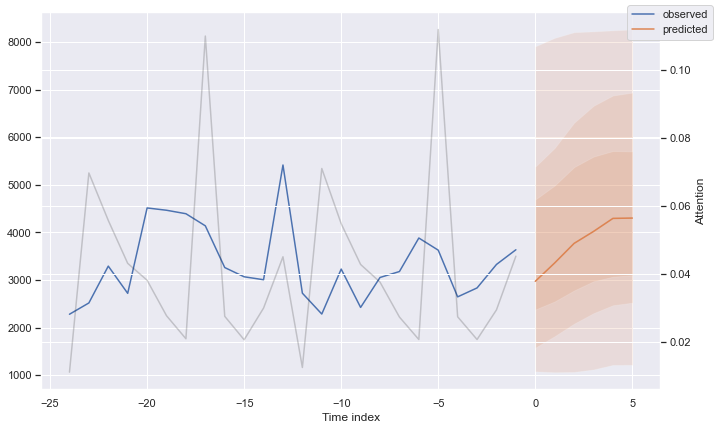

In [30]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

{'attention': <Figure size 720x432 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

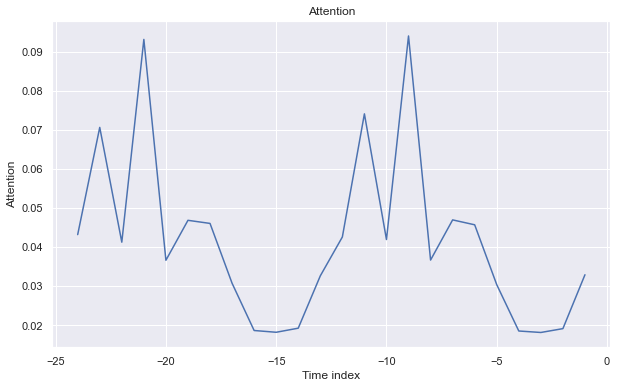

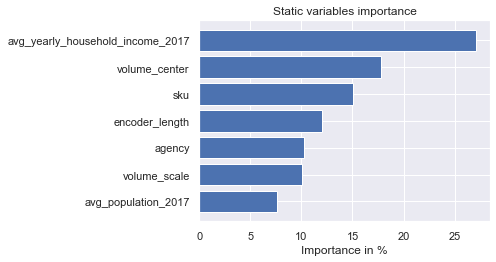

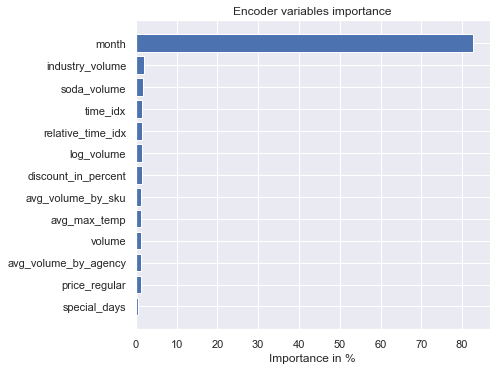

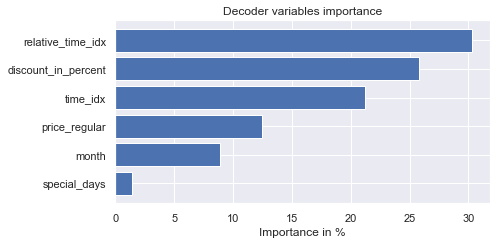

In [31]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [32]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Standa

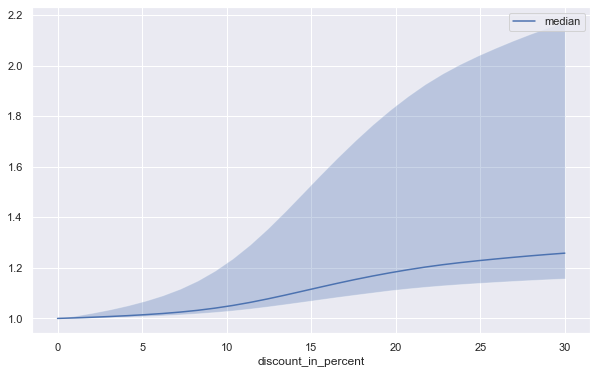

In [33]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

#### RESULTS

## NEXT STEPS

It would be interesting to measure how much the market rises on the days we guess right to estimate possible profits using this algorithm.
